# Airbnb Postings Price Prediction

The objective of this project is two-fold. First we want to most accurately predict the price given posting specifications. Also, we would like to identify which variables are affecting the price the most.

This is the second part of the Luther Project. If you want to see how I gathered data, check this.

In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
plt.style.use('seaborn-poster')
%matplotlib inline

import pickle # for saving data and regression results
import gender_guesser.detector as gender # to predict host gender

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.linear_model import ElasticNet
from sklearn import feature_selection as f_select
from sklearn.externals import joblib

import warnings
warnings.filterwarnings('ignore')

# import data
airbnb = pd.read_json("~/ds/metis/airbnb/airbnbdata.json")

/Users/sungwankim/anaconda2/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/sungwankim/anaconda2/envs/python3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5281 entries, 0 to 5280
Data columns (total 26 columns):
accuracy         5281 non-null object
amenity          5281 non-null object
bath             5281 non-null object
bed              5281 non-null object
bedroom          5281 non-null object
category         5281 non-null object
checkin          5281 non-null object
city             5281 non-null object
cleanliness      5281 non-null object
communication    5281 non-null object
detail           5281 non-null object
guest            5281 non-null object
host             5281 non-null object
host_info        5281 non-null object
language         5281 non-null object
location         5281 non-null object
n_review         5281 non-null object
name             5281 non-null object
price            5281 non-null object
response_rate    5281 non-null object
response_time    5281 non-null object
review           5281 non-null object
rule             5281 non-null object
star             52

In [3]:
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 25)
airbnb.head()

,accuracy,amenity,bath,bed,bedroom,category,checkin,city,cleanliness,communication,detail,guest,...,language,location,n_review,name,price,response_rate,response_time,review,rule,star,url,value
0,Rating 5 out of 5,"[Kitchen, Family/kid friendly, Wireless Intern...",1 bath,3 beds,2 bedrooms,Entire apartment,Rating 5 out of 5,Bronx,Rating 5 out of 5,Rating 5 out of 5,"This modern, quiet loft apartment (800 sq feet...",4 guests,...,"[English, Español]",Rating 4.5 out of 5,13 Reviews,Beautiful Loft near subway,$132,100%,within an hour,[Beautiful comfortable home. We enjoyed our st...,"[No smoking, Not suitable for pets, No parties...",Average 5 out of 5 stars from 13 guest reviews,https://www.airbnb.com/rooms/11486601?location...,Rating 5 out of 5
1,Rating 5 out of 5,"[Kitchen, Wireless Internet, Breakfast, Essent...",1 shared bath,1 bed,1 bedroom,Private room,Rating 5 out of 5,Bronx,Rating 5 out of 5,Rating 5 out of 5,A true New York hidden gem tucked away in hist...,1 guest,...,"[English, Español]",Rating 5 out of 5,3 Reviews,Manhattan Marble Hill Private Sleep'n Suites,$48,100%,within an hour,"[\nGreat location, very personable host.\nWith...","[No smoking, Not suitable for pets, No parties...",Average 5 out of 5 stars from 3 guest reviews,https://www.airbnb.com/rooms/20788666?location...,Rating 5 out of 5
2,Rating 4.5 out of 5,"[Kitchen, Wireless Internet, Essentials, Lapto...",1 shared bath,1 bed,1 bedroom,Private room,Rating 5 out of 5,New York,Rating 4.5 out of 5,Rating 4.5 out of 5,"Huge, cheap, cozy and safe room. Yeshiva Colle...",2 guests,...,"[English, 中文]",Rating 4 out of 5,18 Reviews,Washington Heights! Close to 1 trian. HugeRoom,$42,75%,within a few hours,[Wei gives very detailed descriptions and dire...,"[No smoking, Not suitable for pets, No parties...",Average 4.5 out of 5 stars from 18 guest reviews,https://www.airbnb.com/rooms/7307682?location=...,Rating 4.5 out of 5
3,Rating 5 out of 5,"[Elevator, Kitchen, Wireless Internet, Dryer]",1 bath,2 beds,1 bedroom,Entire apartment,Rating 5 out of 5,New York,Rating 5 out of 5,Rating 5 out of 5,*1-bedroom w/ Queen size bed,4 guests,...,[],Rating 5 out of 5,6 Reviews,"Spacious, artistic 1-bedroom near The Cloisters!",$95,100%,within an hour,[Leyla was a very gracious host. She was very ...,"[No smoking, Not suitable for pets, No parties...",Average 5 out of 5 stars from 6 guest reviews,https://www.airbnb.com/rooms/21007762?location...,Rating 5 out of 5
4,Rating 5 out of 5,"[Kitchen, Wireless Internet, Air conditioning,...",1 private bath,1 bed,1 bedroom,Private room,Rating 5 out of 5,New York,Rating 5 out of 5,Rating 5 out of 5,Hello.,2 guests,...,[Ελληνικά],Rating 4.5 out of 5,27 Reviews,"All Private Bed Room, Living Room & Bath Room!",$78,100%,within an hour,[This place was great! Our first time trying A...,"[No smoking, Not suitable for pets, No parties...",Average 5 out of 5 stars from 27 guest reviews,https://www.airbnb.com/rooms/13674879?location...,Rating 5 out of 5


In [4]:
airbnb.tail()

,accuracy,amenity,bath,bed,bedroom,category,checkin,city,cleanliness,communication,detail,guest,...,language,location,n_review,name,price,response_rate,response_time,review,rule,star,url,value
5276,Rating 5 out of 5,"[Kitchen, Wireless Internet, Free parking on p...",1 bath,1 bed,1 bedroom,Entire cabin,Rating 5 out of 5,Mayne Island,Rating 5 out of 5,Rating 5 out of 5,Appearing in numerous books on natural buildin...,2 guests,...,"[English, Nederlands]",Rating 5 out of 5,299 Reviews,Unique Cob Cottage,$99,100%,within an hour,[Alexis & Manny have built a stunning and invi...,"[No smoking, Not suitable for pets, No parties...",Average 5 out of 5 stars from 299 guest reviews,https://www.airbnb.com/rooms/1720832?location=...,Rating 5 out of 5
5277,Rating 5 out of 5,"[Family/kid friendly, Kitchen, Wireless Intern...",2 baths,2 beds,2 bedrooms,Entire house,Rating 5 out of 5,Joshua Tree,Rating 5 out of 5,Rating 5 out of 5,The Joshua Tree House is a two bed two bath 19...,6 guests,...,[English],Rating 5 out of 5,279 Reviews,The Joshua Tree House,$250,100%,within an hour,[Sara and Rich’s place is just lovely. Stylish...,"[No smoking, Not suitable for pets, No parties...",Average 5 out of 5 stars from 279 guest reviews,https://www.airbnb.com/rooms/32694?location=Li...,Rating 5 out of 5
5278,Rating 5 out of 5,"[Family/kid friendly, Wireless Internet, Free ...",1 bath,2 beds,Studio,Entire cabin,Rating 5 out of 5,Armenia,Rating 5 out of 5,Rating 5 out of 5,"Located in the coffee region, in the Andean mo...",2 guests,...,"[English, Español]",Rating 5 out of 5,123 Reviews,Romantic Cabana with view,$41,100%,within a few hours,[What a place! Just as pictured -- picturesque...,"[Check-in is anytime after 1PM, Check out by 1...",Average 5 out of 5 stars from 123 guest reviews,https://www.airbnb.com/rooms/3993887?location=...,Rating 5 out of 5
5279,Rating 5 out of 5,"[Pets allowed, Family/kid friendly, Kitchen, B...",1.5 baths,2 beds,1 bedroom,Entire bungalow,Rating 5 out of 5,Selat,Rating 4.5 out of 5,Rating 5 out of 5,Hideout is a unique eco stay for adventurous t...,4 guests,...,"[English, Čeština]",Rating 5 out of 5,237 Reviews,HIDEOUT BALI - Eco Bamboo Home,$163,100%,within an hour,"[Hideout is the most serene, secluded, homey, ...","[No smoking, Check-in time is 3PM - 7PM, Check...",Average 5 out of 5 stars from 237 guest reviews,https://www.airbnb.com/rooms/5904771?location=...,Rating 4.5 out of 5
5280,Rating 5 out of 5,"[Kitchen, Family/kid friendly, Pets allowed, F...",1 bath,1 bed,Studio,Entire camper/RV,Rating 5 out of 5,Malibu,Rating 5 out of 5,Rating 4.5 out of 5,Escape civilization to this incredible and pea...,3 guests,...,"[Deutsch, English, Español, Français, Русский]",Rating 5 out of 5,246 Reviews,Malibu Dream Airstream,$550,97%,within a few hours,"[Serene, peaceful, romantic spot. Beautiful in...","[No smoking, No parties or events, Not safe or...",Average 5 out of 5 stars from 246 guest reviews,https://www.airbnb.com/rooms/3406062?location=...,Rating 4.5 out of 5


# Preprocessing
We will first clean up the data before anaylysis.

In [5]:
# drop the columns reserved for NLP
airbnb.drop(['name', 'detail', 'host_info', 'review', 'rule'], axis = 1, inplace = True)

# rearrange the columns
airbnb = airbnb[['city', 'url','category','bed','guest','bedroom','bath','host','amenity',
                 'n_review','star','accuracy','communication','cleanliness','location',
                 'checkin','value','language', 'response_rate', 'response_time', 'price']]

airbnb.head()

,city,url,category,bed,guest,bedroom,bath,host,amenity,n_review,star,accuracy,communication,cleanliness,location,checkin,value,language,response_rate,response_time,price
0,Bronx,https://www.airbnb.com/rooms/11486601?location...,Entire apartment,3 beds,4 guests,2 bedrooms,1 bath,Luis And Oriana,"[Kitchen, Family/kid friendly, Wireless Intern...",13 Reviews,Average 5 out of 5 stars from 13 guest reviews,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 4.5 out of 5,Rating 5 out of 5,Rating 5 out of 5,"[English, Español]",100%,within an hour,$132
1,Bronx,https://www.airbnb.com/rooms/20788666?location...,Private room,1 bed,1 guest,1 bedroom,1 shared bath,Randy,"[Kitchen, Wireless Internet, Breakfast, Essent...",3 Reviews,Average 5 out of 5 stars from 3 guest reviews,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,"[English, Español]",100%,within an hour,$48
2,New York,https://www.airbnb.com/rooms/7307682?location=...,Private room,1 bed,2 guests,1 bedroom,1 shared bath,Wei,"[Kitchen, Wireless Internet, Essentials, Lapto...",18 Reviews,Average 4.5 out of 5 stars from 18 guest reviews,Rating 4.5 out of 5,Rating 4.5 out of 5,Rating 4.5 out of 5,Rating 4 out of 5,Rating 5 out of 5,Rating 4.5 out of 5,"[English, 中文]",75%,within a few hours,$42
3,New York,https://www.airbnb.com/rooms/21007762?location...,Entire apartment,2 beds,4 guests,1 bedroom,1 bath,Leyla,"[Elevator, Kitchen, Wireless Internet, Dryer]",6 Reviews,Average 5 out of 5 stars from 6 guest reviews,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,[],100%,within an hour,$95
4,New York,https://www.airbnb.com/rooms/13674879?location...,Private room,1 bed,2 guests,1 bedroom,1 private bath,Evangelos,"[Kitchen, Wireless Internet, Air conditioning,...",27 Reviews,Average 5 out of 5 stars from 27 guest reviews,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 4.5 out of 5,Rating 5 out of 5,Rating 5 out of 5,[Ελληνικά],100%,within an hour,$78


## City

In [6]:
airbnb.city.value_counts()

New York                   4700
San Francisco               144
Rochester                    80
Nürnberg                     26
Queens                       18
Nuremberg                    13
Florence                      9
Budapest                      7
Split                         6
White Plains                  6
Porto                         6
Ubud                          5
                           ... 
Sechelt                       1
Choeng Thale                  1
Umalas                        1
Suzhou                        1
Fujieda                       1
Cisternino, Brindisi          1
Makawao                       1
Fern Forest                   1
Twentynine Palms              1
Shibuya                       1
Osaka-shi                     1
Nishinari-ku, Ōsaka-shi       1
Name: city, Length: 183, dtype: int64

In [7]:
# drop not NYC
airbnb = airbnb[airbnb.city == "New York"]
airbnb.city.value_counts()

New York    4700
Name: city, dtype: int64

In [8]:
# drop city variable
airbnb.drop('city', axis = 1, inplace = True)

## Url

In [9]:
# check neighborhoods
airbnb['neighborhood'] = airbnb.url.str.split('location=').apply(lambda x: x[1]).str.replace("%20", " ") \
                                   .str.split('%2C').apply(lambda x: x[0]).str.replace("%27", "'")
airbnb.neighborhood.value_counts()

Downtown Manhattan      172
Lower East Side         165
Sugar Hill              163
East Village            155
Hell's Kitchen          155
Peter Cooper Village    143
Upper Manhattan         143
San Juan Hill           143
Marcus Garvey Park      140
West Village            140
Nolita                  137
Cooperative Village     133
                       ... 
Strivers' Row            10
Five Points               9
Battery Park City         8
Tribeca                   8
Two Bridges               8
Carnegie Hill             7
Hamilton Heights          7
Diamond District          5
Rockefeller Center        4
Tudor City                4
Little Syria              2
Marble Hill               1
Name: neighborhood, Length: 71, dtype: int64

In [10]:
# Group the neighborhoods
airbnb.neighborhood.replace(['Upper Manhattan',
 'Marble Hill',
 'Inwood',
 'Fort George',
 'Washington Heights',
 'Hudson Heights',
 'West Harlem',
 'Hamilton Heights',
 'Manhattanville',
 'Morningside Heights',
 'Central Harlem',
 'Harlem',
 "Strivers' Row",
 'Astor Row',
 'Sugar Hill',
 'Marcus Garvey Park',
 'Le Petit Senegal',
 'East Harlem',
 'Upper East Side',
 'Lenox Hill',
 'Carnegie Hill',
 'Yorkville',
 'Upper West Side',
 'Manhattan Valley',
 'Lincoln Square',
 'San Juan Hill'
], 'Uptown', inplace = True)

airbnb.neighborhood.replace(['Midtown',
 'Columbus Circle',
 'Sutton Place',
 'Rockefeller Center',
 'Diamond District',
 'Theater District',
 'Turtle Bay',
 'Tudor City',
 'Little Brazil',
 'Times Square',
 'Hudson Yards',
 "Hell's Kitchen",
 'Garment District',
 'Herald Square',
 'Koreatown',
 'Murray Hill',
 'Tenderloin',
 'Madison Square'], 'Midtown', inplace = True)

airbnb.neighborhood.replace(['Hudson Yards',
 'Kips Bay',
 'Rose Hill',
 'NoMad',
 'Peter Cooper Village',
 'Gas House district',
 'Chelsea',
 'Flatiron District',
 'Gramercy Park',
 'Stuyvesant Square',
 'Union Square',
 'Stuyvesant Town',
 'Gas House district',
 'Meatpacking District',
 'Waterside Plaza'], 'Between Midtown Downtown', inplace = True)

airbnb.neighborhood.replace(['Downtown Manhattan',
 'Little Germany',
 'Alphabet City and Loisaida',
 'East Village',
 'Greenwich Village',
 'NoHo',
 'Bowery',
 'West Village',
 'Lower East Side',
 'SoHo',
 'Nolita',
 'Little Italy',
 'Chinatown',
 'Financial District',
 'Five Points',
 'Cooperative Village',
 'Two Bridges',
 'Tribeca',
 'Civic Center',
 'Radio Row',
 'South Street Seaport',
 'Battery Park City',
 'Little Syria'], 'Downtown', inplace = True)
                            
airbnb.neighborhood.value_counts()

Downtown                    1454
Uptown                      1314
Midtown                     1124
Between Midtown Downtown     808
Name: neighborhood, dtype: int64

In [11]:
# make dummy variables
airbnb = pd.get_dummies(airbnb.neighborhood).join(airbnb)
airbnb.drop('neighborhood', axis = 1, inplace = True)

In [12]:
# check for duplicates
airbnb['url_for_dup'] = airbnb.url.str.split('?').apply(lambda x: x[0])
airbnb.url_for_dup.value_counts()

https://www.airbnb.com/rooms/1080766     7
https://www.airbnb.com/rooms/12358923    6
https://www.airbnb.com/rooms/4774056     6
https://www.airbnb.com/rooms/9411082     6
https://www.airbnb.com/rooms/21275541    6
https://www.airbnb.com/rooms/22345209    6
https://www.airbnb.com/rooms/20570245    5
https://www.airbnb.com/rooms/16119475    5
https://www.airbnb.com/rooms/16661916    5
https://www.airbnb.com/rooms/13239995    5
https://www.airbnb.com/rooms/14538224    5
https://www.airbnb.com/rooms/12187394    5
                                        ..
https://www.airbnb.com/rooms/16403391    1
https://www.airbnb.com/rooms/212199      1
https://www.airbnb.com/rooms/21055896    1
https://www.airbnb.com/rooms/21215200    1
https://www.airbnb.com/rooms/21869123    1
https://www.airbnb.com/rooms/16783828    1
https://www.airbnb.com/rooms/21344762    1
https://www.airbnb.com/rooms/4152389     1
https://www.airbnb.com/rooms/22337697    1
https://www.airbnb.com/rooms/21535963    1
https://www

In [13]:
airbnb.shape

(4700, 25)

In [14]:
# get rid of duplicates
airbnb.drop_duplicates(subset = ['url_for_dup', 'host'], keep = 'first', inplace = True)
airbnb.drop(['url_for_dup', 'url'], axis = 1, inplace = True)

In [15]:
airbnb.shape

(2995, 23)

## Category

In [16]:
airbnb.category.value_counts()

Entire apartment             1558
Private room                 1192
Shared room                    54
Entire loft                    52
Entire house                   37
Entire townhouse               37
Entire condominium             35
Entire place                    6
Entire timeshare                4
Entire guest suite              3
1 bed                           3
2 beds                          2
Entire villa                    2
Entire bed & breakfast          2
Entire serviced apartment       2
Entire floor                    2
Entire boutique hotel           1
5 beds                          1
Entire vacation home            1
6 beds                          1
Name: category, dtype: int64

In [17]:
# get rid of invalid entries
airbnb = airbnb[airbnb.category.str.contains("bed") == False]
# group similar categories together
airbnb.loc[airbnb['category'].str.contains('Entire'), 'category'] = 'Entire apartment'
airbnb.category.value_counts()

Entire apartment    1740
Private room        1192
Shared room           54
Name: category, dtype: int64

In [18]:
# make dummy variables
airbnb = pd.get_dummies(airbnb.category).join(airbnb)
airbnb.drop('category', axis = 1, inplace = True)
airbnb.rename(columns = lambda x: x.replace(" ", "_").lower(), inplace = True)

## Bed

In [19]:
airbnb.bed.value_counts()

1 bed      1728
2 beds      682
3 beds      298
4 beds      151
5 beds       63
6 beds       36
7 beds       13
8 beds        7
9 beds        5
11 beds       1
 ·            1
10 beds       1
Name: bed, dtype: int64

In [20]:
# drop the missing value
airbnb = airbnb[airbnb.bed != " · "]
airbnb['bed'] = pd.to_numeric(airbnb['bed'].str.split().str[0])
airbnb.bed.value_counts()

1     1728
2      682
3      298
4      151
5       63
6       36
7       13
8        7
9        5
11       1
10       1
Name: bed, dtype: int64

## Guest

In [21]:
airbnb.guest.value_counts()

2 guests     1290
4 guests      488
3 guests      352
1 guest       266
6 guests      231
5 guests      133
8 guests       77
7 guests       54
10 guests      47
12 guests      17
9 guests       14
16 guests       6
14 guests       6
11 guests       2
13 guests       1
15 guests       1
Name: guest, dtype: int64

In [22]:
airbnb['guest'] = pd.to_numeric(airbnb['guest'].str.split().str[0])
airbnb.guest.unique()

array([ 2,  4,  1,  6,  7,  5,  3, 12,  9, 14, 10,  8, 11, 16, 13, 15])

## Bedroom

In [23]:
airbnb.bedroom.value_counts()

1 bedroom     1974
2 bedrooms     455
Studio         356
3 bedrooms     128
4 bedrooms      52
5 bedrooms      15
6 bedrooms       4
7 bedrooms       1
Name: bedroom, dtype: int64

In [24]:
# I assumed that studios are different from 1 bedroom
airbnb.bedroom = airbnb.bedroom.str.replace("Studio", "0.5 bedroom")
airbnb.bedroom = pd.to_numeric(airbnb.bedroom.str.split().str[0])
airbnb.bedroom.unique()

array([1. , 2. , 0.5, 3. , 4. , 5. , 7. , 6. ])

## Baths

In [25]:
airbnb.bath.value_counts()

1 bath               1822
1 shared bath         633
2 baths               178
1 private bath        122
1.5 baths              56
2 shared baths         29
0 baths                28
3 baths                21
1.5 shared baths       18
2.5 baths              17
2 private baths        13
1.5 private baths      12
1 bed                  10
3.5 baths               8
Half-bath               5
4 baths                 3
Shared half-bath        2
4.5 baths               2
5 baths                 2
3.5 private baths       1
2.5 private baths       1
5.5 baths               1
3.5 shared baths        1
Name: bath, dtype: int64

In [26]:
# create another variable indicating whether bath is shared or private
airbnb['bath_shared'] = [1 if "shared" in ba else 0 for ba in airbnb["bath"]]
# drop invalid entries
airbnb = airbnb[airbnb.bath.str.contains("bed") == False]
airbnb.bath = airbnb.bath.str.lower().str.replace("shared ", "").str.replace("private ", "").str.replace("half-", "0.5 ")
airbnb['bath'] = pd.to_numeric(airbnb['bath'].str.split().str[0])
airbnb.bath.value_counts()

1.0    2577
2.0     220
1.5      86
0.0      28
3.0      21
2.5      18
3.5      10
0.5       7
4.0       3
4.5       2
5.0       2
5.5       1
Name: bath, dtype: int64

## Host

In [27]:
# let's guess the gender of our host
d = gender.Detector()
airbnb['host_gender'] = airbnb.host.apply(d.get_gender)
airbnb.host_gender.value_counts()

male             1188
female            930
unknown           624
mostly_male       106
mostly_female      91
andy               36
Name: host_gender, dtype: int64

In [28]:
airbnb.host_gender = airbnb.host_gender.str.replace('andy', 'androgynous') # should be androgynous
airbnb[airbnb.host_gender == 'androgynous'][['host', 'host_gender']]

,host,host_gender
2,Wei,androgynous
163,Soon,androgynous
406,Ting,androgynous
609,Pat,androgynous
750,London,androgynous
779,London,androgynous
912,Hea,androgynous
969,Jackie,androgynous
1073,Jue,androgynous
1220,Jeong,androgynous


In [29]:
airbnb.host_gender.replace('male', 0, inplace = True)
airbnb.host_gender.replace('mostly_male', 0.2, inplace = True)
airbnb.host_gender.replace(['androgynous', 'unknown'], 0.5, inplace = True)
airbnb.host_gender.replace('mostly_female', 0.8, inplace = True)
airbnb.host_gender.replace('female', 1, inplace = True)
# change the variable name
airbnb.rename(columns={'host_gender':'host_female'}, inplace=True)
# drop host variable
airbnb.drop('host', axis = 1, inplace = True)

## Amenities

In [30]:
la = list(set([v for l in airbnb.amenity for v in l]))
la

['Smoking allowed',
 'Family/kid friendly',
 'Air conditioning',
 'Elevator',
 'Hangers',
 'Suitable for events',
 'TV',
 'Indoor fireplace',
 'Kitchen',
 'Buzzer/wireless intercom',
 'Pool',
 'Cable TV',
 'Shampoo',
 'Pets allowed',
 'Free parking on premises',
 'Hot tub',
 'Dryer',
 'Hair dryer',
 'Washer',
 'Laptop friendly workspace',
 'Heating',
 'Breakfast',
 'Gym',
 'Iron',
 'Doorman',
 'Private entrance',
 'Essentials',
 'Wireless Internet']

In [31]:
airbnb[la] = pd.DataFrame(airbnb.amenity.apply(lambda x: [1 if a in x else 0 for a in la]).tolist(), index = airbnb.index)
airbnb.drop('amenity', axis = 1, inplace = True)
airbnb.rename(columns=lambda x: x.replace('/', ' ').replace(' ', '_').lower(), inplace=True)
airbnb.head()

,entire_apartment,private_room,shared_room,between_midtown_downtown,downtown,midtown,uptown,bed,guest,bedroom,bath,n_review,...,dryer,hair_dryer,washer,laptop_friendly_workspace,heating,breakfast,gym,iron,doorman,private_entrance,essentials,wireless_internet
2,0,1,0,0,0,0,1,1,2,1.0,1.0,18 Reviews,...,0,0,0,1,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,1,2,4,1.0,1.0,6 Reviews,...,1,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,1,1,2,1.0,1.0,27 Reviews,...,0,0,0,0,1,0,0,0,0,0,0,1
5,0,1,0,0,0,0,1,1,1,1.0,1.0,8 Reviews,...,0,0,0,0,0,0,0,0,0,0,0,1
6,0,1,0,0,0,0,1,1,1,1.0,1.0,8 Reviews,...,0,0,0,0,0,0,0,1,0,0,0,1


## Number of Reviews

In [32]:
airbnb.n_review.value_counts()

3 Reviews      120
4 Reviews      107
6 Reviews       85
5 Reviews       78
8 Reviews       74
7 Reviews       74
9 Reviews       70
14 Reviews      58
10 Reviews      56
19 Reviews      56
11 Reviews      50
12 Reviews      50
              ... 
102 Reviews      1
177 Reviews      1
341 Reviews      1
368 Reviews      1
188 Reviews      1
243 Reviews      1
269 Reviews      1
253 Reviews      1
366 Reviews      1
204 Reviews      1
223 Reviews      1
270 Reviews      1
Name: n_review, Length: 239, dtype: int64

In [33]:
airbnb['n_review'] = pd.to_numeric(airbnb['n_review'].str.split().str[0])
airbnb.n_review.unique()

array([ 18,   6,  27,   8,  13,  93,  10,  23,   5,  42, 124,  94,  79,
        40,  45,  76,  56,  66,   7,  14,  12,  38,  83,  20,  15,  11,
        43,   3,  96,   4,  80,  51,  35, 105,  73,  52,  33,  22,  30,
        70,  49,  37,  17,  44,  21,  59,  28,  31, 117, 118,  16,  72,
        36,  75, 116,  24,   9, 102,  81, 106,  62,  25, 151, 101, 103,
        69,  77, 152,  54, 108,  82, 195, 187, 144,  64,  65, 496,  26,
        34,  46, 173, 141,  68,  55, 109,  47,  53, 139, 274, 186, 345,
       122,  19,  32,  57,  63,  86,  50, 150,  41, 126, 157, 206, 140,
        84,  90, 189, 254,  74, 161, 130,  29,  78, 174, 210, 135, 147,
        98, 230, 156, 190,  67, 112, 100, 205, 158, 167, 115, 123, 133,
        61,  85, 163,  60, 366, 114,  88,  58, 160, 132, 113,  97,  91,
       218,  89, 128,  48, 148,  39,  71, 142, 127, 104, 145, 179, 138,
       159, 143, 193,  99, 182, 180, 244, 110, 119, 188, 111, 120, 164,
        87, 237, 223, 170, 194, 199, 367, 162, 255, 183, 149, 18

## Ratings

In [34]:
airbnb[['star', 'accuracy', 'communication', 'cleanliness', 'location', 'checkin', 'value']].head()

,star,accuracy,communication,cleanliness,location,checkin,value
2,Average 4.5 out of 5 stars from 18 guest reviews,Rating 4.5 out of 5,Rating 4.5 out of 5,Rating 4.5 out of 5,Rating 4 out of 5,Rating 5 out of 5,Rating 4.5 out of 5
3,Average 5 out of 5 stars from 6 guest reviews,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5
4,Average 5 out of 5 stars from 27 guest reviews,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 4.5 out of 5,Rating 5 out of 5,Rating 5 out of 5
5,Average 5 out of 5 stars from 8 guest reviews,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 4 out of 5,Rating 5 out of 5,Rating 5 out of 5
6,Average 5 out of 5 stars from 8 guest reviews,Rating 5 out of 5,Rating 5 out of 5,Rating 5 out of 5,Rating 4.5 out of 5,Rating 5 out of 5,Rating 4.5 out of 5


In [35]:
# extract the first number from a string
airbnb.star = airbnb.star.str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
airbnb.accuracy = airbnb.accuracy.str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
airbnb.communication = airbnb.communication.str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
airbnb.cleanliness = airbnb.cleanliness.str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
airbnb.location = airbnb.location.str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
airbnb.checkin = airbnb.checkin.str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
airbnb.value = airbnb.value.str.extract('(\d*\.\d+|\d+)', expand=False).astype(float)
airbnb[['star', 'accuracy', 'communication', 'cleanliness', 'location', 'checkin', 'value']].head()

,star,accuracy,communication,cleanliness,location,checkin,value
2,4.5,4.5,4.5,4.5,4.0,5.0,4.5
3,5.0,5.0,5.0,5.0,5.0,5.0,5.0
4,5.0,5.0,5.0,5.0,4.5,5.0,5.0
5,5.0,5.0,5.0,5.0,4.0,5.0,5.0
6,5.0,5.0,5.0,5.0,4.5,5.0,4.5


In [36]:
# drop overall ratings and use individual ratings
airbnb.drop('star', axis = 1, inplace = True)

## Language

In [37]:
airbnb.language = airbnb.language.apply(lambda x: x[0].split(", ") if x else [])
s = list(set([v for l in airbnb.language for v in l]))
s

['Dansk',
 'English',
 'العربية',
 'Français',
 'Русский',
 'Bahasa Indonesia',
 'Norsk',
 'עברית',
 'українська',
 'Bahasa Malaysia',
 'Ελληνικά',
 'Hindi',
 'Tagalog',
 'Suomi',
 'Türkçe',
 'Sign Language',
 'Italiano',
 'Português',
 '中文',
 '한국어',
 'Čeština',
 'Deutsch',
 'Punjabi',
 'Nederlands',
 'Polski',
 'Svenska',
 'ภาษาไทย',
 'Bengali',
 'Español',
 'Magyar',
 '日本語']

In [38]:
airbnb[s] = pd.DataFrame(airbnb.language.apply(lambda x: [1 if a in x else 0 for a in s]).tolist(), index = airbnb.index)
airbnb.drop('language', axis = 1, inplace = True)
airbnb.head()

,entire_apartment,private_room,shared_room,between_midtown_downtown,downtown,midtown,uptown,bed,guest,bedroom,bath,n_review,...,한국어,Čeština,Deutsch,Punjabi,Nederlands,Polski,Svenska,ภาษาไทย,Bengali,Español,Magyar,日本語
2,0,1,0,0,0,0,1,1,2,1.0,1.0,18,...,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,2,4,1.0,1.0,6,...,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,1,2,1.0,1.0,27,...,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,0,0,0,0,1,1,1,1.0,1.0,8,...,0,0,0,0,0,0,0,0,0,1,0,0
6,0,1,0,0,0,0,1,1,1,1.0,1.0,8,...,0,0,0,0,0,0,0,0,0,1,0,0


In [39]:
# group similar languages together
airbnb['south_east_asia'] = airbnb['Bahasa Malaysia'] + airbnb['Bahasa Indonesia'] + airbnb['Tagalog'] + airbnb['ภาษาไทย']
airbnb['east_asia'] = airbnb['日本語'] + airbnb['中文'] + airbnb['한국어']
airbnb['south_asia'] = airbnb['Bengali'] + airbnb['Hindi'] + airbnb['Punjabi']
airbnb['east_europe'] = airbnb['Polski'] + airbnb['Türkçe'] + airbnb['українська'] + airbnb['Čeština'] + airbnb['Русский']
airbnb['west_europe'] = airbnb['Suomi'] + airbnb['Svenska'] + airbnb['Norsk'] + airbnb['Deutsch'] + airbnb['Nederlands'] + airbnb['Français'] + airbnb['Dansk'] + airbnb['English']
airbnb['south_europe'] = airbnb['Italiano'] + airbnb['Ελληνικά'] + airbnb['Español'] +  airbnb['Português']
airbnb['middle_east'] = airbnb['العربية'] + airbnb['עברית']
airbnb.drop(['Bahasa Malaysia',
 'Ελληνικά',
 'Italiano',
 'Polski',
 'Magyar',
 'Türkçe',
 'العربية',
 'Bahasa Indonesia',
 '日本語',
 'Bengali',
 'Português',
 'українська',
 'עברית',
 'Suomi',
 'Sign Language',
 'Svenska',
 'Tagalog',
 'Norsk',
 'Deutsch',
 'Čeština',
 'Hindi',
 'Español',
 'Nederlands',
 'Punjabi',
 'ภาษาไทย',
 'Français',
 'Dansk',
 '中文',
 '한국어',
 'English',
 'Русский'], axis = 1, inplace = True)
airbnb.head()

,entire_apartment,private_room,shared_room,between_midtown_downtown,downtown,midtown,uptown,bed,guest,bedroom,bath,n_review,...,iron,doorman,private_entrance,essentials,wireless_internet,south_east_asia,east_asia,south_asia,east_europe,west_europe,south_europe,middle_east
2,0,1,0,0,0,0,1,1,2,1.0,1.0,18,...,0,0,0,1,1,0,1,0,0,1,0,0
3,1,0,0,0,0,0,1,2,4,1.0,1.0,6,...,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,1,2,1.0,1.0,27,...,0,0,0,0,1,0,0,0,0,0,1,0
5,0,1,0,0,0,0,1,1,1,1.0,1.0,8,...,0,0,0,0,1,0,0,0,0,1,1,0
6,0,1,0,0,0,0,1,1,1,1.0,1.0,8,...,1,0,0,0,1,0,0,0,0,1,2,0


## Response

In [40]:
airbnb.response_rate.value_counts()

100%    2374
90%      158
80%       55
96%       31
94%       29
60%       24
95%       23
83%       22
93%       21
86%       20
70%       19
88%       17
        ... 
81%        2
63%        1
20%        1
65%        1
56%        1
54%        1
79%        1
74%        1
58%        1
71%        1
61%        1
69%        1
Name: response_rate, Length: 47, dtype: int64

In [41]:
airbnb['response_rate'] = pd.to_numeric(airbnb['response_rate'].replace('[\%,]', '', regex = True))
airbnb.response_rate.unique()

array([ 75, 100,  90,  33,  80,  25,  50,  88,  57,  96,  67,  94,  60,
        83,  87,  95,  97,  98,  93,  85,  92,  70,  78,  86,  89,  64,
        91,  82,  77,  99,  68,  65,  58,  69,  79,  84,  81,  40,  71,
         0,  54,  20,  61,  74,  63,  76,  56])

In [42]:
airbnb['response_time'].value_counts()

within an hour        2158
within a few hours     529
within a day           270
a few days or more      18
Name: response_time, dtype: int64

In [43]:
airbnb = airbnb.join(pd.get_dummies(airbnb.response_time))
airbnb.drop('response_time', axis = 1, inplace = True)
airbnb.rename(columns = lambda x: x.replace(" ", "_"), inplace = True)

## Price

In [44]:
airbnb.price.unique()

array(['$42', '$95', '$78', '$60', '$65', '$35', '$75', '$40', '$47',
       '$50', '$55', '$85', '$30', '$49', '$37', '$83', '$72', '$115',
       '$125', '$48', '$81', '$10', '$100', '$89', '$155', '$68', '$59',
       '$23', '$44', '$34', '$150', '$52', '$39', '$24', '$33', '$21',
       '$80', '$112', '$63', '$99', '$28', '$46', '$105', '$79', '$45',
       '$58', '$43', '$70', '$54', '$69', '$51', '$110', '$41', '$96',
       '$61', '$67', '$109', '$25', '$113', '$210', '$94', '$170', '$101',
       '$31', '$29', '$53', '$57', '$19', '$129', '$350', '$97', '$32',
       '$62', '$325', '$189', '$90', '$77', '$180', '$193', '$278',
       '$229', '$135', '$140', '$38', '$16', '$250', '$149', '$575',
       '$249', '$195', '$219', '$190', '$82', '$130', '$178', '$93',
       '$160', '$120', '$76', '$15', '$127', '$119', '$91', '$131',
       '$145', '$114', '$56', '$111', '$123', '$137', '$176', '$175',
       '$66', '$64', '$300', '$98', '$71', '$74', '$260', '$299', '$147',
       

In [2]:
airbnb['price'] = pd.to_numeric(airbnb['price'].replace('[\$,]', '', regex = True))
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
# and our data is ready for anaylysis!
airbnb.head()

NameError: name 'pd' is not defined

In [53]:
airbnb.sum(axis=0)

entire_apartment               1738.0
private_room                   1184.0
shared_room                      53.0
between_midtown_downtown        392.0
downtown                       1007.0
midtown                         553.0
uptown                         1023.0
bed                            5324.0
guest                          9912.0
bedroom                        3750.0
bath                           3329.0
n_review                     148310.0
accuracy                      14247.0
communication                 14538.5
cleanliness                   13904.5
location                      14402.5
checkin                       14501.0
value                         13929.5
response_rate                287385.0
price                        407893.0
bath_shared                     681.0
host_female                    1354.0
smoking_allowed                 105.0
family_kid_friendly            1404.0
air_conditioning                 14.0
elevator                        985.0
hangers     

In [54]:
# remove value with only one count
airbnb.drop(['private_entrance'], axis = 1, inplace = True)

In [55]:
# No missing values!
airbnb[airbnb.isnull().any(axis = 1)]

,entire_apartment,private_room,shared_room,between_midtown_downtown,downtown,midtown,uptown,bed,guest,bedroom,bath,n_review,accuracy,communication,cleanliness,location,checkin,value,response_rate,price,bath_shared,host_female,smoking_allowed,family_kid_friendly,air_conditioning,elevator,hangers,suitable_for_events,tv,indoor_fireplace,kitchen,buzzer_wireless_intercom,pool,cable_tv,shampoo,pets_allowed,free_parking_on_premises,hot_tub,dryer,hair_dryer,washer,laptop_friendly_workspace,heating,breakfast,gym,iron,doorman,essentials,wireless_internet,south_east_asia,east_asia,south_asia,east_europe,west_europe,south_europe,middle_east,a_few_days_or_more,within_a_day,within_a_few_hours,within_an_hour


In [56]:
# Move price to the beginning and reset index
airbnb = airbnb.set_index('price').reset_index()

In [57]:
# Pickle airbnb pandas dataframe
airbnb.to_pickle('airbnb_data.pkl')

# Exploratory Data Analysis

First, we will explore the distribution of our dependent variable - price.

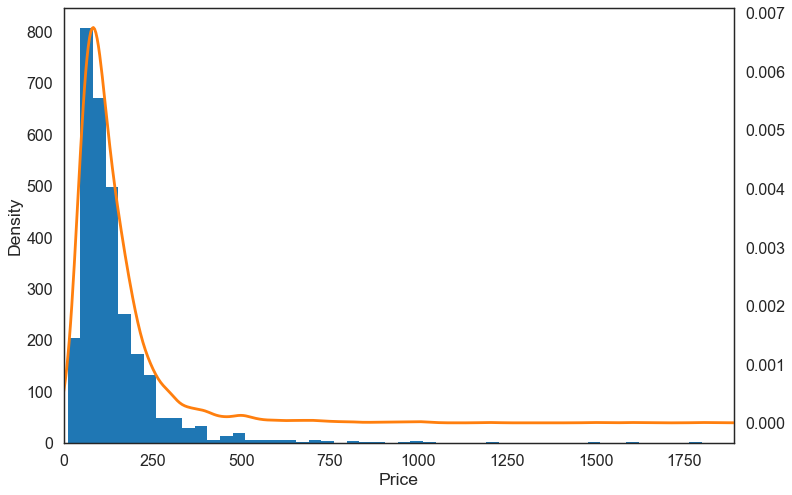

In [47]:
ax = airbnb.price.plot(kind = 'hist', bins = 50, figsize = (12, 8), xlim = (0))
plt.xlabel("Price")
airbnb.price.plot(kind = 'kde', ax = ax, secondary_y = True);

As you can see there is a skew in the distribution of the price, and there are some outliers. We will use boxplot to identify them.

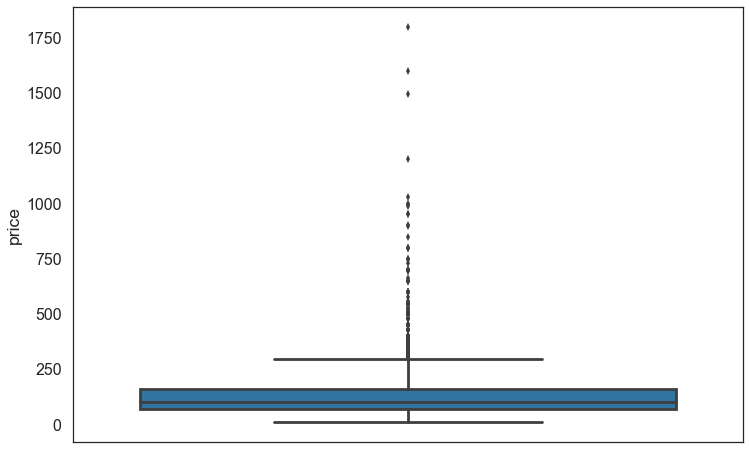

In [48]:
fig, ax = plt.subplots(figsize = (12,8))
sns.boxplot(airbnb.price, orient = "v");

In [49]:
airbnb[airbnb.price > 1000]

,entire_apartment,private_room,shared_room,between_midtown_downtown,downtown,midtown,uptown,bed,guest,bedroom,bath,n_review,accuracy,communication,cleanliness,location,checkin,value,response_rate,price,bath_shared,host_female,smoking_allowed,family_kid_friendly,air_conditioning,elevator,hangers,suitable_for_events,tv,indoor_fireplace,kitchen,buzzer_wireless_intercom,pool,cable_tv,shampoo,pets_allowed,free_parking_on_premises,hot_tub,dryer,hair_dryer,washer,laptop_friendly_workspace,heating,breakfast,gym,iron,doorman,private_entrance,essentials,wireless_internet,south_east_asia,east_asia,south_asia,east_europe,west_europe,south_europe,middle_east,a_few_days_or_more,within_a_day,within_a_few_hours,within_an_hour
2777,1,0,0,1,0,0,0,6,15,5.0,2.0,4,5.0,5.0,4.0,5.0,5.0,5.0,100,1600,0,0.2,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3010,1,0,0,1,0,0,0,6,10,4.0,4.5,11,5.0,5.0,5.0,5.0,5.0,4.5,100,1495,0,1.0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3208,1,0,0,1,0,0,0,10,16,6.0,3.5,38,4.5,5.0,5.0,5.0,5.0,4.5,100,1029,0,0.0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4040,1,0,0,0,1,0,0,6,8,4.0,3.0,14,5.0,5.0,4.5,5.0,5.0,5.0,90,1800,0,1.0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4052,1,0,0,0,1,0,0,2,5,2.0,2.0,49,5.0,5.0,5.0,5.0,5.0,4.5,100,1200,0,0.0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0


Let's explore the correlations between variables.

In [50]:
airbnb.corr()

,entire_apartment,private_room,shared_room,between_midtown_downtown,downtown,midtown,uptown,bed,guest,bedroom,bath,n_review,accuracy,communication,cleanliness,location,checkin,value,response_rate,price,bath_shared,host_female,smoking_allowed,family_kid_friendly,air_conditioning,elevator,hangers,suitable_for_events,tv,indoor_fireplace,kitchen,buzzer_wireless_intercom,pool,cable_tv,shampoo,pets_allowed,free_parking_on_premises,hot_tub,dryer,hair_dryer,washer,laptop_friendly_workspace,heating,breakfast,gym,iron,doorman,private_entrance,essentials,wireless_internet,south_east_asia,east_asia,south_asia,east_europe,west_europe,south_europe,middle_east,a_few_days_or_more,within_a_day,within_a_few_hours,within_an_hour
entire_apartment,1.000000,-0.963758,-0.159639,0.070559,0.039936,0.087548,-0.161728,0.414015,0.476322,0.254334,0.121860,-0.040095,-0.010493,-0.063547,0.046959,0.113388,-0.085831,-0.101113,-0.021464,0.416189,-0.645828,-0.031034,-0.060398,0.308456,-0.041644,-0.010780,-0.079836,-0.009694,-0.051905,0.051635,0.130858,-0.080999,-0.011992,0.134555,-0.084544,0.019222,-0.073179,-0.021764,-0.074889,-0.065122,-0.054471,-0.046854,-0.096096,-0.078094,0.003559,-0.120895,-0.008536,-0.021735,-0.088640,-0.029075,-0.012924,-0.042875,-0.023388,-0.001155,-0.083887,-0.053186,0.001644,0.021849,0.021998,0.046300,-0.057619
private_room,-0.963758,1.000000,-0.109503,-0.071079,-0.028689,-0.093709,0.155940,-0.404804,-0.455215,-0.243540,-0.122197,0.051692,0.022709,0.069709,-0.039616,-0.104882,0.096948,0.106673,0.020667,-0.393301,0.670114,0.022428,0.060333,-0.291308,0.034399,0.005817,0.068562,0.012466,0.051147,-0.048020,-0.126712,0.089944,0.015425,-0.125032,0.067710,-0.017109,0.067699,0.024730,0.058980,0.068162,0.058581,0.049547,0.069862,0.071289,-0.003819,0.126819,0.009676,0.022553,0.083086,0.033923,0.015054,0.036220,0.020094,0.009226,0.086160,0.051618,0.003290,-0.019160,-0.022604,-0.051246,0.061778
shared_room,-0.159639,-0.109503,1.000000,0.000124,-0.042638,0.020565,0.025546,-0.044655,-0.090265,-0.046438,-0.001863,-0.041887,-0.044938,-0.021180,-0.028369,-0.034369,-0.038945,-0.017993,0.003498,-0.095323,-0.073379,0.032638,0.001782,-0.071327,0.027869,0.018640,0.043755,-0.010008,0.004129,-0.014696,-0.018685,-0.031031,-0.012398,-0.038672,0.064451,-0.008312,0.022148,-0.010417,0.060780,-0.009587,-0.013820,-0.008772,0.099530,0.027178,0.000872,-0.018833,-0.004000,-0.002470,0.022814,-0.017197,-0.007551,0.025719,0.012785,-0.029837,-0.006270,0.007158,-0.018299,-0.010508,0.001680,0.017118,-0.013921
between_midtown_downtown,0.070559,-0.071079,0.000124,1.000000,-0.278665,-0.186147,-0.282019,0.000387,0.017267,0.004449,0.016297,-0.012011,0.010746,0.009661,-0.012180,0.132294,0.011035,-0.020945,-0.012146,0.112593,-0.027751,-0.011905,0.000887,-0.009949,0.031297,0.032123,-0.023933,-0.019883,-0.007567,0.036309,0.007356,0.028385,0.018572,0.031760,-0.017477,-0.049004,-0.022711,-0.009967,-0.005568,-0.013701,-0.010616,-0.003259,-0.007849,-0.000143,-0.037489,-0.033296,-0.013670,-0.007143,-0.001871,0.043595,-0.021842,-0.034616,-0.004079,-0.022811,-0.052842,-0.022045,-0.000248,-0.004764,0.049899,0.024163,-0.051988
downtown,0.039936,-0.028689,-0.042638,-0.278665,1.000000,-0.341804,-0.517845,-0.062912,-0.051416,0.019437,-0.046432,-0.032371,-0.005746,0.007089,-0.025424,0.104422,0.022965,-0.050071,-0.018459,0.088386,-0.043132,-0.012344,-0.005933,-0.061523,-0.007669,-0.144016,0.008903,0.035730,-0.024630,-0.038338,0.056448,0.029702,-0.050287,-0.045267,0.057486,0.007272,-0.062253,-0.015332,0.021609,0.039342,-0.059412,0.067654,0.009460,0.004902,0.023307,0.041369,-0.005857,-0.013117,0.109904,0.040223,0.008682,-0.001823,-0.026254,-0.017542,0.021369,0.000007,-0.007756,0.044950,0.055907,-0.009400,-0.035740
midtown,0.087548,-0.093709,0.020565,-0.186147,-0.341804,1.000000,-0.345918,0.091299,0.093973,0.034244,0.042782,0.011148,-0.056858,-0.039330,0.012369,0.156035,-0.060328,-0.027667,-0.025662,0.066896,-0.054679,0.004285,-0.035203,0.048501,-0.007605,0.144878,-0.004190,-0.008152,-0.009661,0.00

In [3]:
# We can create a heatmap using seaborn.
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(airbnb.corr());

NameError: name 'plt' is not defined

Since we have a lot of variables, let's create a pairplot with some variables.

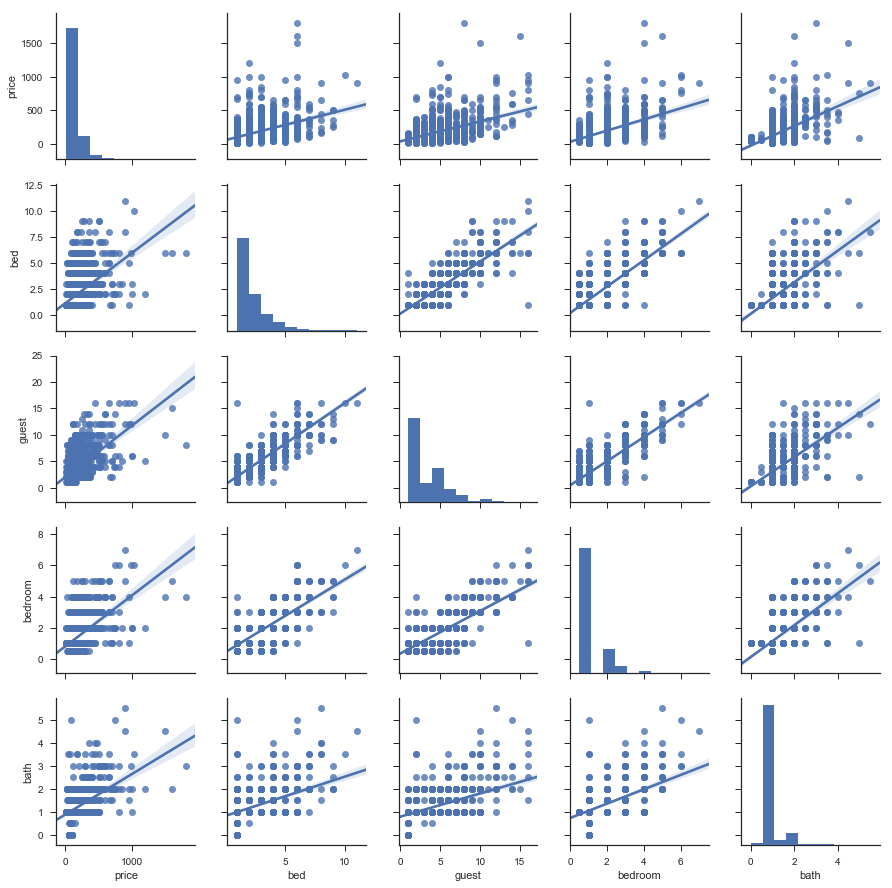

In [52]:
sns.set(style="ticks")
sns.pairplot(airbnb[['price', 'bed', 'guest', 'bedroom', 'bath']], kind="reg");

# Linear Regression

In [58]:
# # to help with modeling
# " + ".join(airbnb.columns.tolist())

In [59]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('price ~ entire_apartment + private_room + shared_room + between_midtown_downtown + \
                       downtown + midtown + uptown + bed + guest + bedroom + bath + n_review + accuracy + \
                       communication + cleanliness + location + checkin + value + response_rate + bath_shared + \
                       host_female + hot_tub + elevator + family_kid_friendly + hangers + doorman + \
                       suitable_for_events + iron + breakfast + tv + pool + shampoo + pets_allowed + hair_dryer + \
                       laptop_friendly_workspace + heating + buzzer_wireless_intercom + indoor_fireplace + \
                       smoking_allowed + cable_tv + kitchen + wireless_internet + free_parking_on_premises + \
                       essentials + gym + dryer + air_conditioning + washer + south_east_asia + east_asia + \
                       south_asia + east_europe + west_europe + south_europe + middle_east + a_few_days_or_more + \
                       within_a_day + within_a_few_hours + within_an_hour', data = airbnb, return_type = "dataframe")
# Create your model
model = sm.OLS(y, X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     57.16
Date:                Fri, 26 Jan 2018   Prob (F-statistic):               0.00
Time:                        16:05:03   Log-Likelihood:                -17364.
No. Observations:                2975   AIC:                         3.484e+04
Df Residuals:                    2918   BIC:                         3.518e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -150.3673     29.649     -5.072      0.000    -208.503     -92.232
entire_apartment             -5.7377     11.099     -0.517      0.605     -27.501      16.025
private_room                -57.0570     10.982     -5.196      0.000     -78.590     -35.524
shared_room                 -87.5726     12.589     -6.956      0.000    -112.257     -62.888
between_midtown_downtown    -18.6928      8.439     -2.215      0.027     -35.240      -2.146
downtown                    -25.8339      7.850     -3.291      0.001     -41.226     -10.442
midtown                     -42.4475      8.137     -5.217      0.000     -58.402     -26.493
uptown                      -63.3931      7.572     -8.372      0.000     -78.240     -48.546
bed                         -12.8406      2.745     -4.677      0.000     -18.224      -7.458
guest                         9.9611      1.753      5.683      0.000       6.524      13.398
bedroom                      40.1925      3.711     10.831      0.000      32.916      47.469
bath                         84.7841      4.738     17.894      0.000      75.493      94.075
n_review                     -0.1893      0.031     -6.163      0.000      -0.250      -0.129
accuracy                     19.7217      7.320      2.694      0.007       5.368      34.075
communication                 7.8497      8.869      0.885      0.376      -9.540      25.240
cleanliness                  11.7705      5.462      2.155      0.031       1.060      22.481
location                     26.7539      6.693      3.997      0.000      13.631      39.877
checkin                       6.8759      8.559      0.803      0.422      -9.905      23.657
value                        -7.0265      7.083     -0.992      0.321     -20.914       6.861
response_rate                -0.2673      0.221     -1.212      0.226      -0.700       0.165
bath_shared                 -15.7796      5.146     -3.066      0.002     -25.869      -5.690
host_female                   2.7810      3.663      0.759      0.448      -4.401       9.963
hot_tub                      12.1444     12.588      0.965      0.335     -12.537      36.826
elevator                     14.2097      9.737      1.459      0.145      -4.882      33.301
family_kid_friendly           1.7650      9.728      0.181      0.856     -17.309      20.839
hangers                      -8.9731     13.556     -0.662      0.508     -35.553      17.607
doorman                      15.1296     10.871      1.392      0.164      -6.187      36.446
suitable_for_events          34.6827     12.747      2.721      0.007       9.688      59.677
iron                          5.0910     11.647      0.437      0.662     -17.746      27.928
breakfast                    -3.3167     11.093     -0.299      0.765     -

In [60]:
# Pickle fit to a file 
fit.save('airbnb_sm_model.pkl')

## LR Assumptions

We will check Linear Regression assumptions and see if there is any violations. First we will check normal variance of residuals or homoskedasticity.

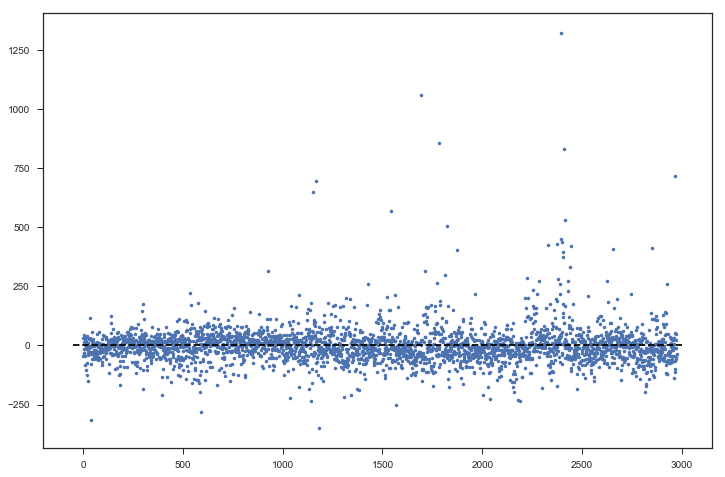

In [61]:
# Use statsmodels to plot the residuals
fit.resid.plot(style = '.', figsize=(12,8), zorder = 1)
plt.hlines(y = 0, xmin = -50, xmax = 3000, color = "black", linestyles = '--', zorder = 2);

Overall, the residual plot looks pretty much like noise except some outliers as we go further out. Let's check if the residuals are normally distributed using Q-Q plot.

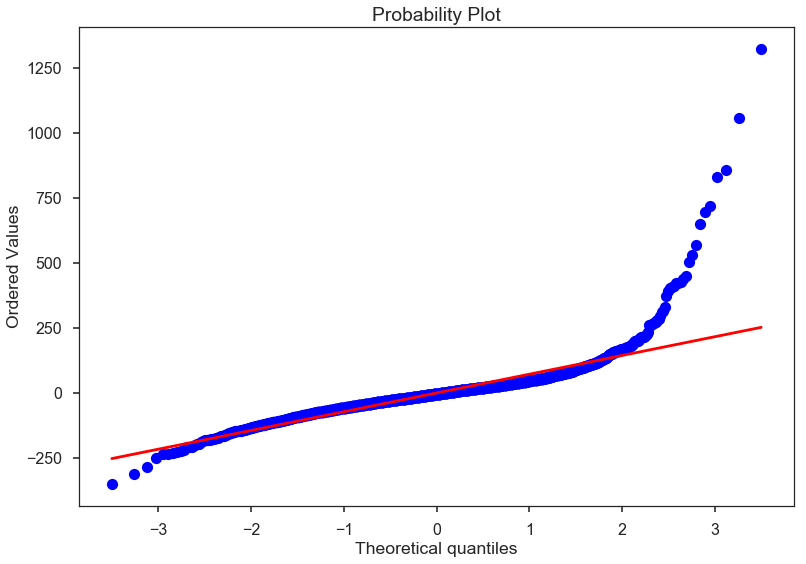

In [62]:
plt.style.use('seaborn-poster')
stats.probplot(fit.resid, dist = "norm", plot = plt);

You can see there is a significant deviation of blue points from the red line. In order to make residuals normal we will log transform our target variable.

In [1]:
plt.style.use('seaborn-poster')
ax = airbnb.price.plot(kind = "hist", bins = 50, title = 'Price Distribution', xlim = (0))
plt.xlabel("price")
airbnb.price.plot(kind = 'kde', ax = ax, secondary_y = True);

NameError: name 'plt' is not defined

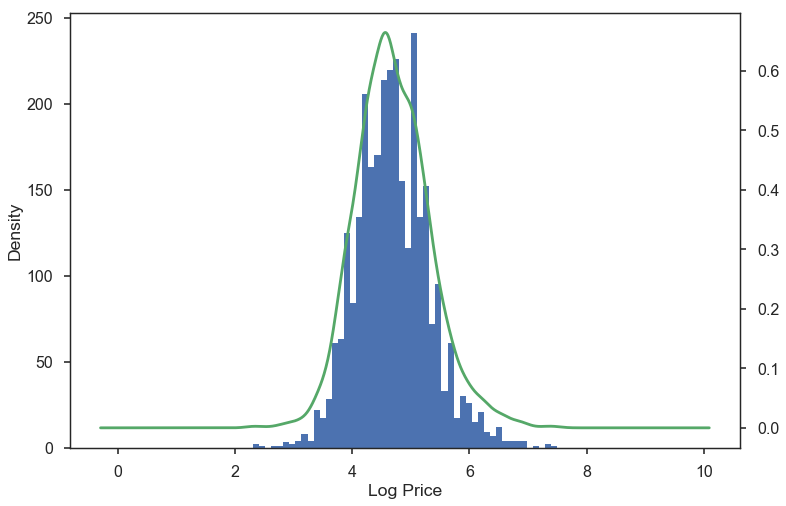

In [64]:
# Log Transformation
airbnb['log_price'] = np.log(airbnb.price)
ax = airbnb.log_price.plot(kind = "hist", bins = 50, figsize = (12, 8))
plt.xlabel("Log Price")
airbnb.log_price.plot(kind = 'kde', ax = ax, secondary_y = True);

The dependent variable looks approximately normal!

In [65]:
lmf = smf.ols('log_price ~ entire_apartment + private_room + shared_room + between_midtown_downtown + \
                       downtown + midtown + uptown + bed + guest + bedroom + bath + n_review + accuracy + \
                       communication + cleanliness + location + checkin + value + response_rate + bath_shared + \
                       host_female + hot_tub + elevator + family_kid_friendly + hangers + doorman + \
                       suitable_for_events + iron + breakfast + tv + pool + shampoo + pets_allowed + hair_dryer + \
                       laptop_friendly_workspace + heating + buzzer_wireless_intercom + indoor_fireplace + \
                       smoking_allowed + cable_tv + kitchen + wireless_internet + free_parking_on_premises + \
                       essentials + gym + dryer + air_conditioning + washer + south_east_asia + east_asia + \
                       south_asia + east_europe + west_europe + south_europe + middle_east + a_few_days_or_more + \
                       within_a_day + within_a_few_hours + within_an_hour', data=airbnb)
# Fit the model
fitf = lmf.fit()
# Print summary statistics of the model's performance
fitf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     82.33
Date:                Fri, 26 Jan 2018   Prob (F-statistic):               0.00
Time:                        16:05:06   Log-Likelihood:                -1460.9
No. Observations:                2975   AIC:                             3036.
Df Residuals:                    2918   BIC:                             3378.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.1797      0.141      8.343      0.000       0.902       1.457
entire_apartment              0.8519      0.053     16.095      0.000       0.748       0.956
private_room                  0.4242      0.052      8.099      0.000       0.321       0.527
shared_room                  -0.0964      0.060     -1.606      0.108      -0.214       0.021
between_midtown_downtown      0.4163      0.040     10.344      0.000       0.337       0.495
downtown                      0.3579      0.037      9.560      0.000       0.285       0.431
midtown                       0.2983      0.039      7.686      0.000       0.222       0.374
uptown                        0.1071      0.036      2.967      0.003       0.036       0.178
bed                          -0.0367      0.013     -2.803      0.005      -0.062      -0.011
guest                         0.0260      0.008      3.113      0.002       0.010       0.042
bedroom                       0.1757      0.018      9.930      0.000       0.141       0.210
bath                          0.2555      0.023     11.306      0.000       0.211       0.300
n_review                     -0.0013      0.000     -8.855      0.000      -0.002      -0.001
accuracy                      0.1049      0.035      3.005      0.003       0.036       0.173
communication                 0.0289      0.042      0.682      0.495      -0.054       0.112
cleanliness                   0.1269      0.026      4.873      0.000       0.076       0.178
location                      0.2195      0.032      6.877      0.000       0.157       0.282
checkin                       0.0511      0.041      1.251      0.211      -0.029       0.131
value                        -0.0722      0.034     -2.137      0.033      -0.138      -0.006
response_rate                -0.0007      0.001     -0.694      0.488      -0.003       0.001
bath_shared                  -0.1884      0.025     -7.677      0.000      -0.237      -0.140
host_female                   0.0142      0.017      0.811      0.418      -0.020       0.048
hot_tub                       0.0027      0.060      0.044      0.965      -0.115       0.120
elevator                      0.0447      0.046      0.963      0.336      -0.046       0.136
family_kid_friendly           0.0009      0.046      0.019      0.985      -0.090       0.092
hangers                      -0.0743      0.065     -1.150      0.250      -0.201       0.052
doorman                       0.0719      0.052      1.387      0.166      -0.030       0.174
suitable_for_events           0.0855      0.061      1.406      0.160      -0.034       0.205
iron                         -0.0755      0.056     -1.360      0.174      -0.184       0.033
breakfast                    -0.0533      0.053     -1.007      0.314      

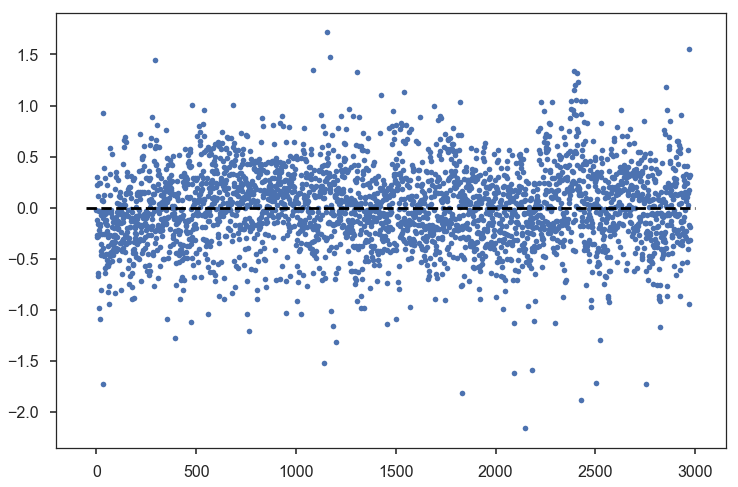

In [66]:
# Use statsmodels to plot the residuals
fitf.resid.plot(style='.', figsize=(12,8), zorder = 1)
plt.hlines(y = 0, xmin = -50, xmax = 3000, color = "black", linestyles = '--', zorder = 2);

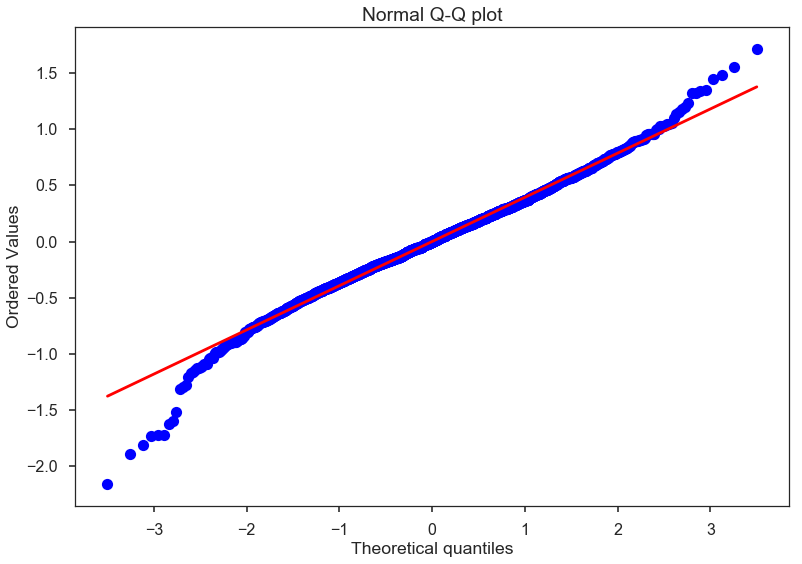

In [67]:
stats.probplot(fitf.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot");

Since we log transformed our y variable, the R squared no longer is comparable to the previous R squared. Therefore, we will compute R squared manually.

In [68]:
y = airbnb.log_price
X = airbnb.drop(['log_price','price'], 1)
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
lr.fit(X_train, y_train)

y_obs = np.exp(y_test)
y_pred = np.exp(lr.predict(X_test))
y_mean = np.mean(y_obs)
R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
R2

0.500807746724985

In [69]:
y = airbnb.price
X = airbnb.drop(['log_price','price'], 1)
lr = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5253880256575176

In [70]:
# Pickle fitf to a file
fitf.save('airbnb_log_sm_model.pkl')

## Box-Cox

In [71]:
lamb = stats.boxcox_normmax(airbnb.price, brack=(-1.9, 1.9), method='mle')
print(lamb)

-0.16528504410117517


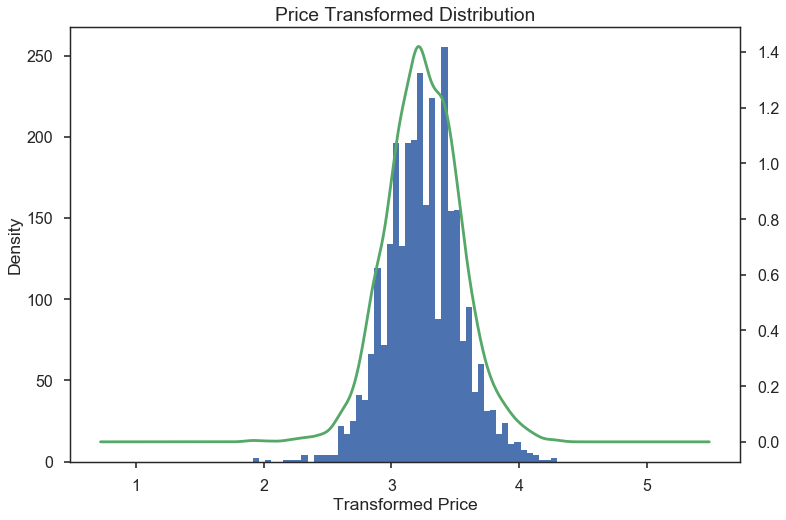

In [72]:
y_t = (np.power(airbnb.price, -0.16528504410117517)-1)/-0.16528504410117517
ax = y_t.plot(kind = "hist", bins = 50, figsize = (12, 8))
plt.title("Price Transformed Distribution")
plt.xlabel("Transformed Price")
plt.ylabel("Frequency")
y_t.plot(kind = 'kde', ax = ax, secondary_y = True);

In [73]:
# Create your model
model = sm.OLS(y_t, X)
# Fit your model to your training set
fitt = model.fit()
# Print summary statistics of the model's performance
fitt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                     79.50
Date:                Fri, 26 Jan 2018   Prob (F-statistic):               0.00
Time:                        16:05:07   Log-Likelihood:                 846.99
No. Observations:                2975   AIC:                            -1580.
Df Residuals:                    2918   BIC:                            -1238.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
entire_apartment              1.0582      0.049     21.492      0.000       0.962       1.155
private_room                  0.8609      0.049     17.614      0.000       0.765       0.957
shared_room                   0.5930      0.050     11.744      0.000       0.494       0.692
between_midtown_downtown      0.6829      0.037     18.359      0.000       0.610       0.756
downtown                      0.6561      0.036     18.105      0.000       0.585       0.727
midtown                       0.6320      0.037     17.239      0.000       0.560       0.704
uptown                        0.5411      0.036     15.227      0.000       0.471       0.611
bed                          -0.0140      0.006     -2.330      0.020      -0.026      -0.002
guest                         0.0096      0.004      2.492      0.013       0.002       0.017
bedroom                       0.0742      0.008      9.109      0.000       0.058       0.090
bath                          0.1017      0.010      9.772      0.000       0.081       0.122
n_review                     -0.0006   6.74e-05     -8.872      0.000      -0.001      -0.000
accuracy                      0.0469      0.016      2.916      0.004       0.015       0.078
communication                 0.0120      0.019      0.614      0.539      -0.026       0.050
cleanliness                   0.0602      0.012      5.022      0.000       0.037       0.084
location                      0.1050      0.015      7.146      0.000       0.076       0.134
checkin                       0.0236      0.019      1.257      0.209      -0.013       0.060
value                        -0.0347      0.016     -2.233      0.026      -0.065      -0.004
response_rate                -0.0003      0.000     -0.522      0.602      -0.001       0.001
bath_shared                  -0.0927      0.011     -8.203      0.000      -0.115      -0.071
host_female                   0.0066      0.008      0.823      0.411      -0.009       0.022
smoking_allowed              -0.0007      0.027     -0.027      0.978      -0.054       0.052
family_kid_friendly          -0.0005      0.021     -0.025      0.980      -0.042       0.041
air_conditioning              0.0021      0.057      0.037      0.970      -0.110       0.115
elevator                      0.0173      0.021      0.811      0.418      -0.025       0.059
hangers                      -0.0345      0.030     -1.158      0.247      -0.093       0.024
suitable_for_events           0.0322      0.028      1.150      0.250      -0.023       0.087
tv                           -0.0202      0.035     -0.576      0.565      -0.089       0.049
indoor_fireplace              0.0436      0.027      1.632      0.103      -0.009       0.096
kitchen                      -0.0414      0.022     -1.874      0.061      

Since the Box-Cox transformation resulted similarly as Logarithmic transformation, we will use the log tranformation from here on out for interpretability

## Polynomial

In [74]:
y = airbnb.price
X = airbnb.drop(['log_price', 'price'], 1)

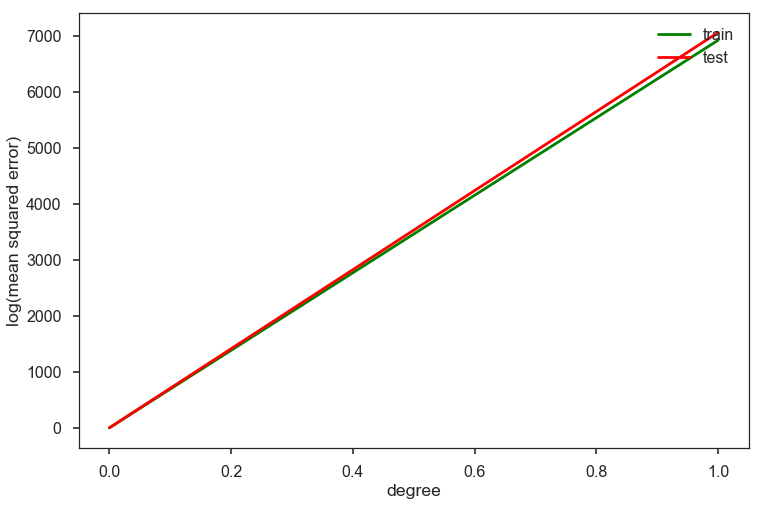

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Step through degrees from 1 to 2 and store the training and test (generalization) error.
# create array of zeros,
train_error = np.empty(2)
test_error = np.empty(2)
for degree in range(1, 2):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize = (12,8))
plt.plot(np.arange(2), train_error, color='green', label='train')
plt.plot(np.arange(2), test_error, color='red', label='test')
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper right');

In [76]:
degree = 2
# Generate the model type with make_pipeline
# This tells it the first step is to generate 2nd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept = False))
# Fit our model to the training data
est.fit(X_train, y_train)
est.score(X_test, y_test)

-0.32859020875759426

In [77]:
# Now with Log Transformation
y = airbnb.log_price
X = airbnb.drop(['log_price','price'], 1)

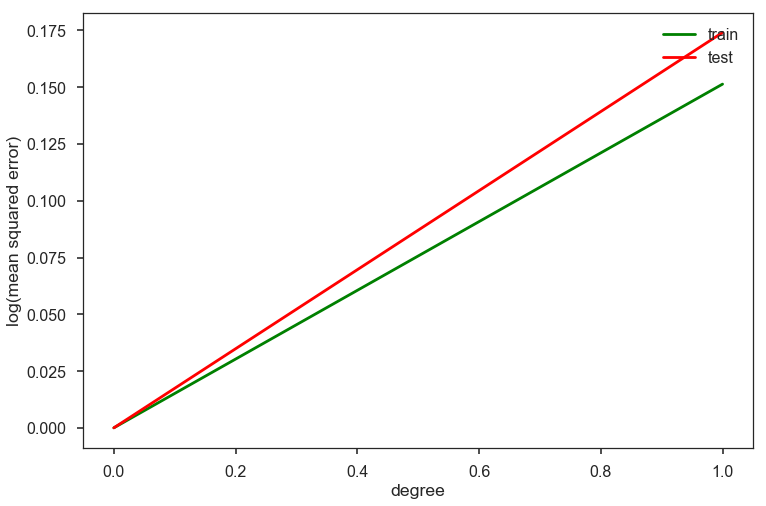

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Step through degrees from 1 to 2 and store the training and test (generalization) error.
# create array of zeros,
train_error = np.empty(2)
test_error = np.empty(2)
for degree in range(1, 2):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize = (12,8))
plt.plot(np.arange(2), train_error, color='green', label='train')
plt.plot(np.arange(2), test_error, color='red', label='test')
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper right');

In [79]:
degree = 2
# Generate the model type with make_pipeline
# This tells it the first step is to generate 2nd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression(fit_intercept = False))
# Fit our model to the training data
est.fit(X_train, y_train)

y_obs = np.exp(y_test)
y_pred = np.exp(est.predict(X_test))
y_mean = np.mean(y_obs)
R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
R2

-inf

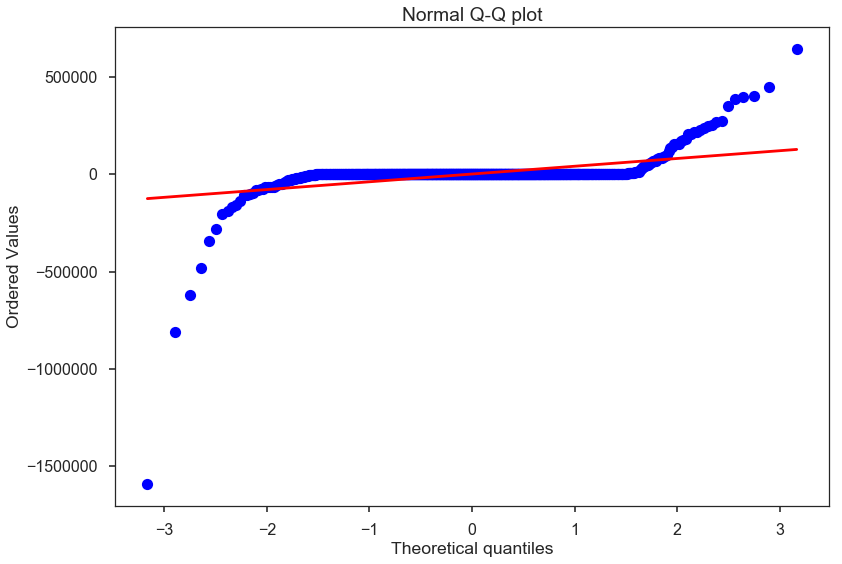

In [80]:
residuals = y_test - est.predict(X_test)
stats.probplot(residuals, dist = "norm", plot = plt)
plt.title("Normal Q-Q plot");

# Cross-Validation

## Test / Train Split

In [81]:
y = airbnb.price
X = airbnb.drop(['log_price','price'], 1)
lr = LinearRegression()
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
lr.score(X_test, y_test)

0.5033246207414017

In [82]:
y = airbnb.log_price
X = airbnb.drop(['log_price','price'], 1)
lr = LinearRegression()
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data

y_obs = np.exp(y_test)
y_pred = np.exp(lr.predict(X_test))
y_mean = np.mean(y_obs)
R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
R2

0.5300067625930346

## Cross-Validation

In [83]:
y = airbnb.price
X = airbnb.drop(['log_price','price'], 1)

# 10-fold cross-validation
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv = 10, scoring = 'r2')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(np.mean(scores))

0.364103299050325


In [84]:
y = airbnb.price
X = airbnb.drop(['log_price','price'], 1)

est = LinearRegression()

kf = KFold(n = len(X), n_folds = 10)

all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 


# get indices of corresponding train & test
for train, test in kf:
    x_train = X.iloc[train]
    y_train = y.iloc[train]
    x_test = X.iloc[test]
    y_test = y.iloc[test]
    pvals = []

    est = LinearRegression()        
    est.fit(x_train, y_train)
    r_2=est.score(x_test,y_test)
    all_scores.append(r_2)
        
np.mean(all_scores)

0.364103299050325

In [85]:
y = airbnb.log_price
X = airbnb.drop(['log_price','price'],1)

est = LinearRegression()

kf = KFold(n = len(X), n_folds = 10)

all_scores=[]

for train, test in kf:
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    lr = LinearRegression()        
    lr.fit(X_train, y_train)
    
    y_obs = np.exp(y_test)
    y_pred = np.exp(lr.predict(X_test))
    y_mean = np.mean(y_obs)
    R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
    all_scores.append(R2)
        
np.mean(all_scores)

0.5072669627651084

# Regularization

In [86]:
# normalize features to values between 0 and 1
airbnb_trans = preprocessing.normalize(airbnb, axis = 0)

# turn back in DF
airbnb_trans = pd.DataFrame(airbnb_trans, columns = airbnb.columns)

y_trans = airbnb_trans['log_price']
X_trans = airbnb_trans.drop(['log_price','price'],1)

X_trans.describe()

,entire_apartment,private_room,shared_room,between_midtown_downtown,downtown,midtown,uptown,bed,guest,bedroom,bath,n_review,accuracy,communication,cleanliness,location,checkin,value,response_rate,bath_shared,host_female,smoking_allowed,family_kid_friendly,air_conditioning,elevator,hangers,suitable_for_events,tv,indoor_fireplace,kitchen,buzzer_wireless_intercom,pool,cable_tv,shampoo,pets_allowed,free_parking_on_premises,hot_tub,dryer,hair_dryer,washer,laptop_friendly_workspace,heating,breakfast,gym,iron,doorman,essentials,wireless_internet,south_east_asia,east_asia,south_asia,east_europe,west_europe,south_europe,middle_east,a_few_days_or_more,within_a_day,within_a_few_hours,within_an_hour
count,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000,2975.000000
mean,0.014013,0.011566,0.002447,0.006655,0.010667,0.007905,0.010751,0.015057,0.015333,0.015726,0.017175,0.012474,0.018298,0.018312,0.018275,0.018307,0.018310,0.018295,0.018244,0.008772,0.013377,0.003444,0.012595,0.001258,0.010549,0.002892,0.003276,0.002255,0.003682,0.017317,0.007854,0.001681,0.007940,0.002304,0.006189,0.003773,0.003311,0.005283,0.001302,0.001872,0.004974,0.002045,0.004633,0.004305,0.004062,0.005304,0.009436,0.016964,0.001026,0.004245,0.001917,0.003966,0.011525,0.008563,0.002468,0.001426,0.005523,0.007731,0.015615
std,0.011824,0.014228,0.018173,0.017086,0.014914,0.016545,0.014853,0.010462,0.010053,0.009427,0.006417,0.013439,0.001148,0.000902,0.001475,0.001002,0.000941,0.001190,0.001811,0.016102,0.012539,0.018011,0.013325,0.018294,0.014997,0.018108,0.018042,0.018198,0.017963,0.006023,0.016569,0.018260,0.016528,0.018192,0.017261,0.017945,0.018036,0.017559,0.018291,0.018241,0.017649,0.018223,0.017742,0.017824,0.017881,0.017553,0.015722,0.006955,0.018308,0.017839,0.018237,0.017903,0.014261,0.016214,0.018170,0.018281,0.017485,0.016627,0.009609
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008414,0.004602,0.006238,0.000000,0.000751,0.007642,0.011241,0.007820,0.011344,0.009391,0.009769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008414,0.009204,0.012476,0.015348,0.003003,0.017194,0.018736,0.017595,0.017016,0.018782,0.017583,0.018886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.023987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008414,0.009204,0.012476,0.015348,0.007507,0.019105,0.018736,0.017595,0.018907,0.018782,0.017583,0.018886,0.000000,0.014696,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019815,0.000000,0.0

## Ridge

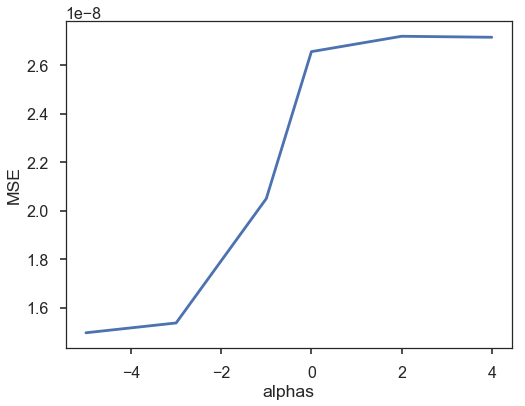

In [87]:
# Test, train, split option via Ridge 
alphas=[1e-5,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size = 0.3)

def make_estimator(est,alpha):
    est.alpha = alpha
    model = est.fit(X_train, y_train)
    mse = np.mean(y_test - model.predict(X_test)) ** 2
    return mse
    
# Get scores
all_mse=[]    
for a in alphas:    
    all_mse.append(make_estimator(Ridge(), a))
    
# plot of model
plt.figure(figsize = (8,6))
plt.plot(np.log10(alphas), all_mse)
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

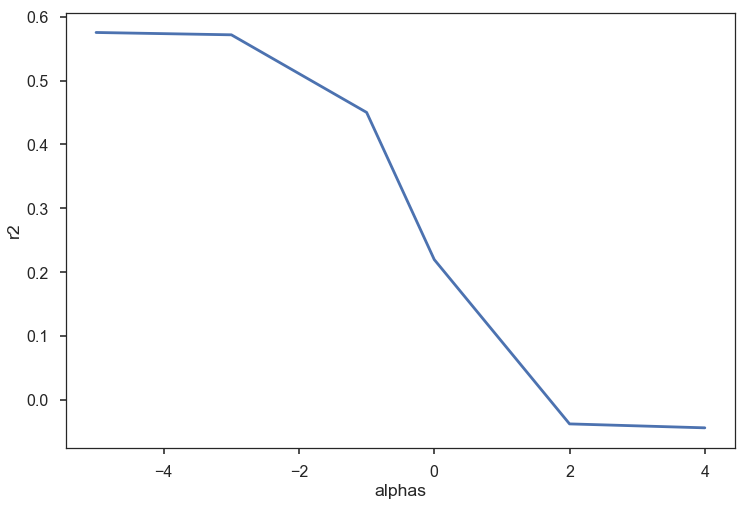

In [88]:
# Test, train, split option via Ridge 
alphas=[1e-5,1e-3,1e-1,1,100,10000]
X_train, X_test, y_train, y_test = train_test_split(X_trans, y_trans, test_size = 0.3)

def make_estimator(est,alpha):
    est.alpha = alpha
    model = est.fit(X_train, y_train)
    y_obs = np.exp(258.5413579407905 * y_test)
    y_pred = np.exp(258.5413579407905 * est.predict(X_test))
    y_mean = np.mean(y_obs)
    R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
    return R2
    
# Get scores
all_r2=[]    
for a in alphas:    
    all_r2.append(make_estimator(Ridge(), a))
    
# plot of model
plt.figure(figsize = (12, 8))
plt.plot(np.log10(alphas), all_r2)
plt.xlabel('alphas')
plt.ylabel('r2')
plt.show()

In [89]:
kf = KFold(len(X_trans), n_folds = 10, shuffle = True)

all_scores = []
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10]

for train, test in kf:
    x_train = X_trans.iloc[train]
    y_train = y_trans.iloc[train]
    x_test = X_trans.iloc[test]
    y_test = y_trans.iloc[test]
    mse_score = []
    r2 = []
    for a in alphas:
        est = Ridge(alpha = a, tol = 0.001)
        est.fit(x_train, y_train)
        mse = np.mean((y_test - est.predict(x_test)) ** 2)
        mse_score.append(mse)
        r2.append(est.score(x_test,y_test))
            
    all_scores.append(r2)
pd.DataFrame(all_scores, columns = alphas).mean(0)

0.0001     0.589823
0.0010     0.589450
0.0100     0.582583
0.1000     0.562273
1.0000     0.462037
5.0000     0.235205
10.0000    0.142999
dtype: float64

In [90]:
airbnb.log_price.iloc[0]/airbnb_trans.log_price.iloc[0]

258.5413579407905

In [91]:
y = airbnb_trans.price
X = airbnb_trans.drop(['log_price','price'], 1)

est = Ridge(alpha = 1e-03)

kf = KFold(n = len(X), n_folds = 10)

all_scores=[]

for train, test in kf:
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    est.fit(X_train, y_train)
    
    y_obs = 258.5413579407905 * y_test
    y_pred = 258.5413579407905 * est.predict(X_test)
    y_mean = np.mean(y_obs)
    R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
    all_scores.append(R2)

np.mean(all_scores)

0.3672273429920284

In [92]:
y = airbnb_trans.log_price
X = airbnb_trans.drop(['log_price','price'], 1)

est = Ridge(alpha = 1e-04)

kf = KFold(n = len(X), n_folds = 10)

all_scores=[]

for train, test in kf:
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    est.fit(X_train, y_train)
    
    y_obs = np.exp(258.5413579407905 * y_test)
    y_pred = np.exp(258.5413579407905 * est.predict(X_test))
    y_mean = np.mean(y_obs)
    R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
    all_scores.append(R2)

np.mean(all_scores)

0.5071058367525221

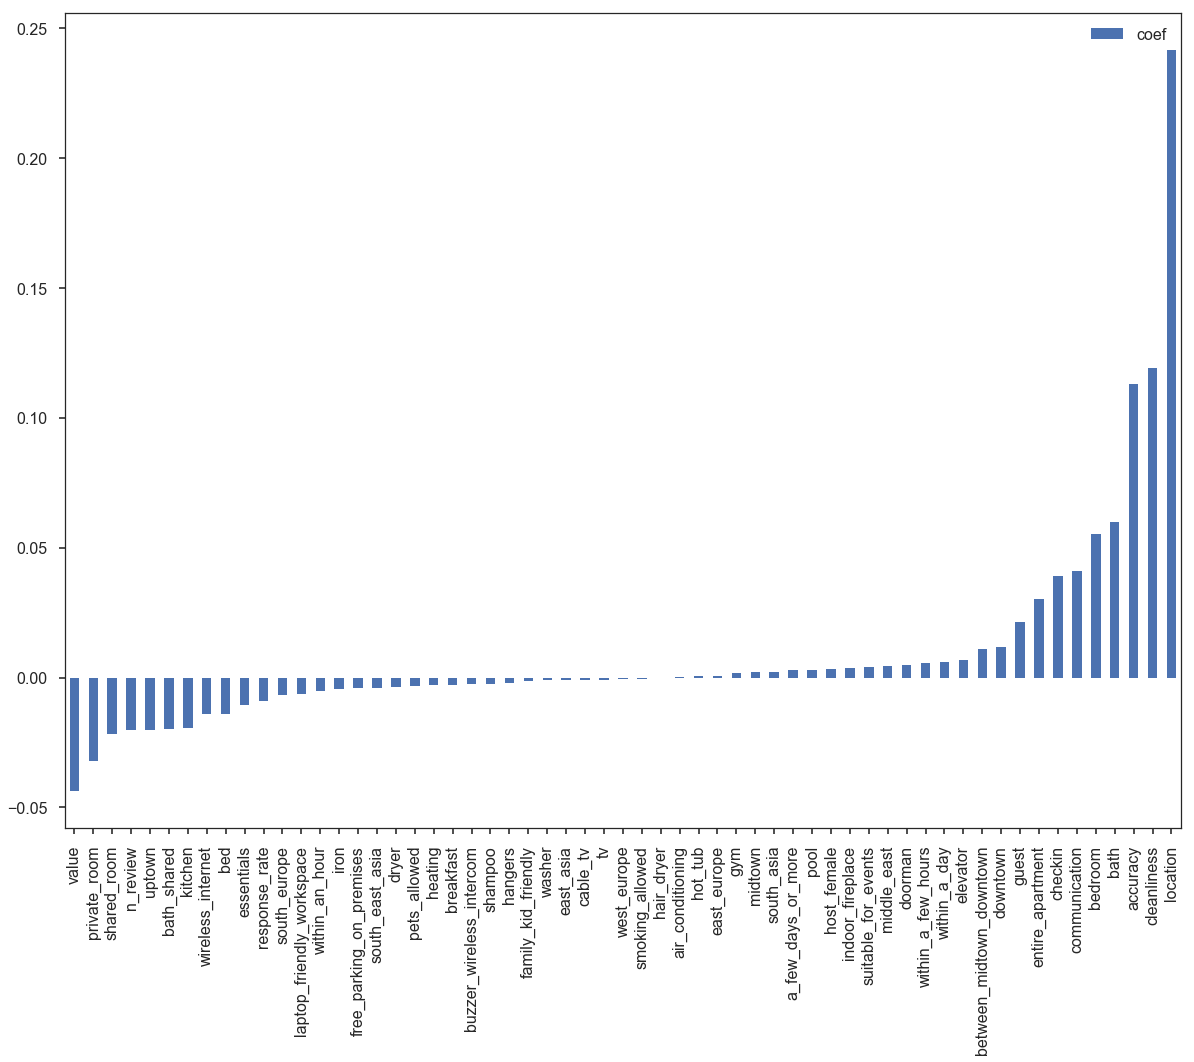

In [93]:
est = Ridge(alpha = 1e-04)
est.fit(X_train, y_train)
pd.DataFrame(est.coef_, X.columns, columns = ["coef"]).sort_values('coef').plot(kind = "bar", figsize = (20, 15));

## Lasso

In [94]:
kf = KFold(len(X_trans), n_folds = 10, shuffle = True)

all_scores = []
alphas = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]


for train, test in kf:
    x_train = X_trans.iloc[train]
    y_train = y_trans.iloc[train]
    x_test = X_trans.iloc[test]
    y_test = y_trans.iloc[test]
    mse_score = []
    r2 = []
    for a in alphas:
        est = Lasso(alpha = a, tol = 0.001)
        est.fit(x_train, y_train)
        mse = np.mean((y_test - est.predict(x_test)) ** 2)
        mse_score.append(mse)
        r2.append(est.score(x_test,y_test))
            
    all_scores.append(r2)
pd.DataFrame(all_scores, columns = alphas).mean(0)

1.000000e-10    0.593552
1.000000e-09    0.593576
1.000000e-08    0.593611
1.000000e-07    0.591419
1.000000e-06    0.560446
1.000000e-05    0.214570
dtype: float64

In [95]:
y = airbnb.price
X = airbnb.drop(['log_price','price'],1)

est = Lasso(alpha = 1e-10)

kf = KFold(n = len(X), n_folds = 10)

all_scores=[]

for train, test in kf:
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    est.fit(X_train, y_train)
    
    y_obs = y_test
    y_pred = est.predict(X_test)
    y_mean = np.mean(y_obs)
    R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
    all_scores.append(R2)

np.mean(all_scores)

0.36410547846208685

In [96]:
y = airbnb_trans.log_price
X = airbnb_trans.drop(['log_price','price'],1)

est = Lasso(alpha = 1e-10)

kf = KFold(n = len(X), n_folds = 10)

all_scores=[]

for train, test in kf:
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    est = Lasso(alpha = 1e-10)
    est.fit(X_train, y_train)
    
    y_obs = np.exp(y_test)
    y_pred = np.exp(est.predict(X_test))
    y_mean = np.mean(y_obs)
    R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
    all_scores.append(R2)

np.mean(all_scores)

0.4985795921370997

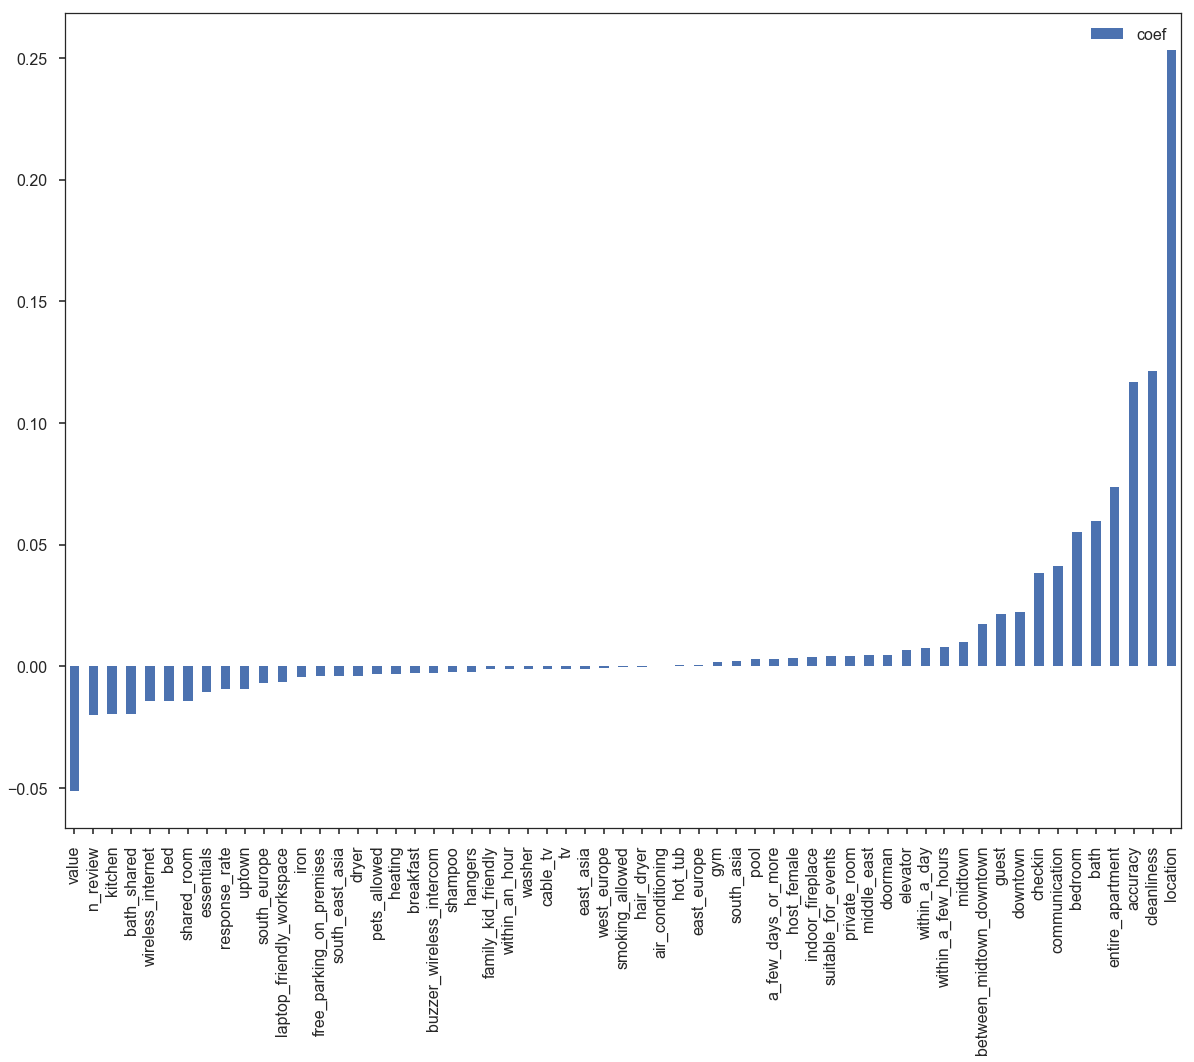

In [97]:
est = Lasso(alpha = 1e-10)
est.fit(X_train, y_train)
pd.DataFrame(est.coef_, X.columns, columns = ["coef"]).sort_values('coef').plot(kind = "bar", figsize = (20, 15));

## ElasticNet

In [98]:
kf = KFold(len(X_trans), n_folds = 10, shuffle = True)

all_scores = []
alphas = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6]


for train, test in kf:
    x_train = X_trans.iloc[train]
    y_train = y_trans.iloc[train]
    x_test = X_trans.iloc[test]
    y_test = y_trans.iloc[test]
    mse_score = []
    r2 = []
    for a in alphas:
        est = ElasticNet(alpha = a, tol = 0.001)
        est.fit(x_train, y_train)
        mse = np.mean((y_test - est.predict(x_test)) ** 2)
        mse_score.append(mse)
        r2.append(est.score(x_test,y_test))
            
    all_scores.append(r2)
pd.DataFrame(all_scores, columns = alphas).mean(0)

1.000000e-15    0.589906
1.000000e-10    0.589907
1.000000e-09    0.589921
1.000000e-08    0.589999
1.000000e-07    0.589692
1.000000e-06    0.567190
dtype: float64

In [99]:
y = airbnb.price
X = airbnb.drop(['log_price','price'],1)

est = ElasticNet(alpha = 1e-08)

kf = KFold(n = len(X), n_folds = 10)

all_scores=[]

for train, test in kf:
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    est.fit(X_train, y_train)
    
    y_obs = y_test
    y_pred = est.predict(X_test)
    y_mean = np.mean(y_obs)
    R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
    all_scores.append(R2)

np.mean(all_scores)

0.36410550049970836

In [100]:
y = airbnb_trans.log_price
X = airbnb_trans.drop(['log_price','price'],1)

est = ElasticNet(alpha = 1e-08)

kf = KFold(n = len(X), n_folds = 10)

all_scores=[]

for train, test in kf:
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_test = X.iloc[test]
    y_test = y.iloc[test]
    
    est = Lasso(alpha = 1e-08)
    est.fit(X_train, y_train)
    
    y_obs = np.exp(y_test)
    y_pred = np.exp(est.predict(X_test))
    y_mean = np.mean(y_obs)
    R2 = 1 - np.sum(np.power(y_obs - y_pred, 2)) / np.sum(np.power(y_obs - y_mean, 2))
    all_scores.append(R2)

np.mean(all_scores)

0.4981362762816768

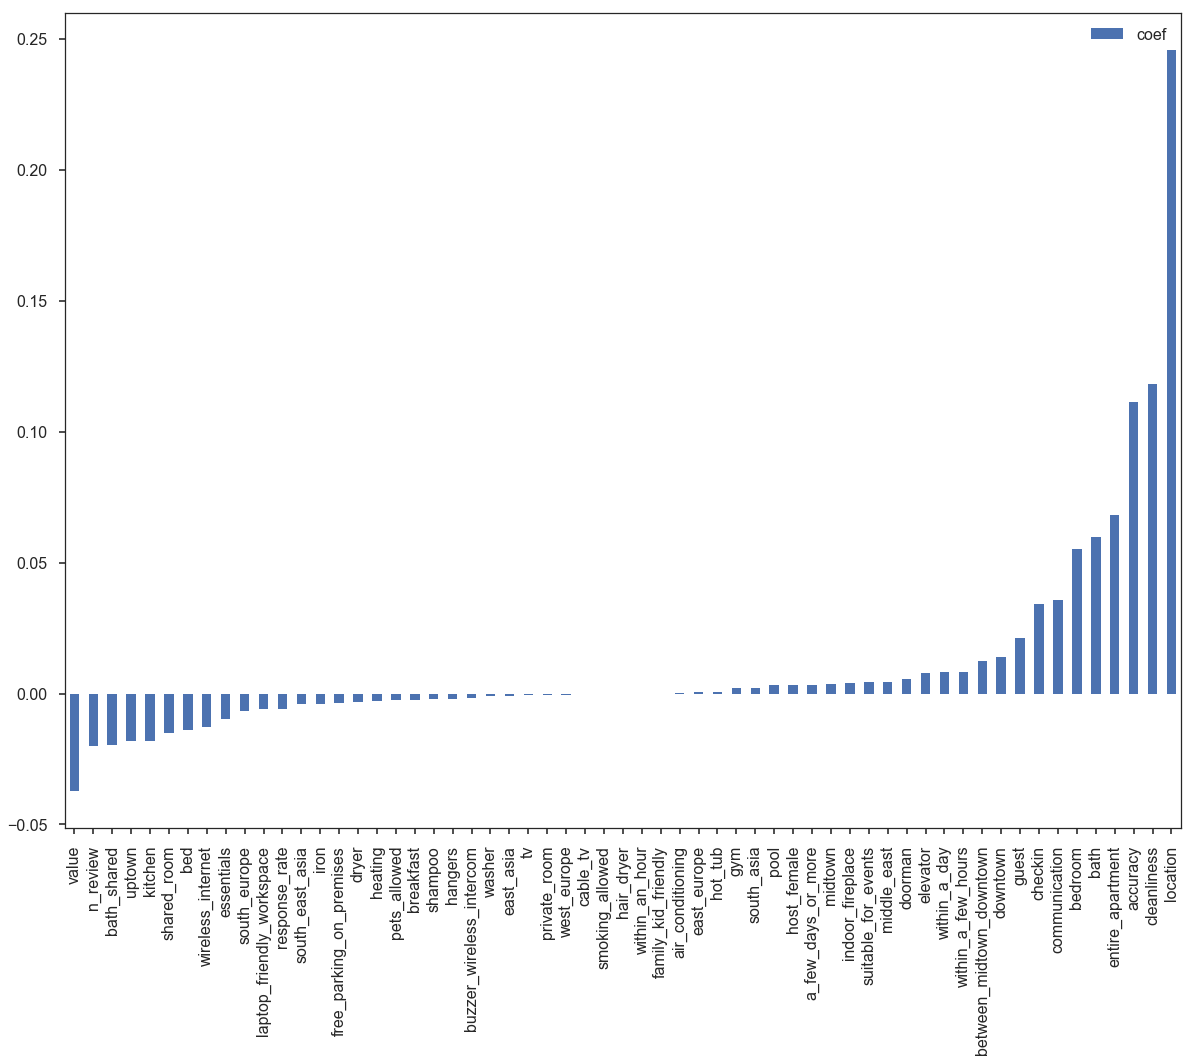

In [101]:
est = ElasticNet(alpha = 1e-08)
est.fit(X_train, y_train)
pd.DataFrame(est.coef_, X.columns, columns = ["coef"]).sort_values('coef').plot(kind = "bar", figsize = (20, 15));